In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math

from sklearn import metrics
from random import randint
from matplotlib import style

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('curriculum_logs.csv')

# concatenate and change date type columns to the respective type 
df['date_time'] = df.date + ' ' + df.time
df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S')
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time).dt.time
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.created_at = pd.to_datetime(df.created_at)
df.deleted_at = pd.to_datetime(df.deleted_at)

# missing entirety of columns
df.drop(['Unnamed: 0', 'id', 'slack','deleted_at'], inplace = True, axis = 1)

# let's clean up the dataset
df.dropna(inplace = True)

# set the index
df = df.set_index(df.date)

# let's rename some columns
df.rename(columns = {'path':'endpoint', 'ip':'source_ip', 'name':'cohort_name'}, inplace = True)

# add program name to dataframe
df['program_name'] = df.program_id.map({1.0: 'PHP Full Stack Web Development',
                                        2.0: 'Java Full Stack Web Development',
                                        3.0: 'Data Science',
                                        4.0: 'Front End Web Development'})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847329 entries, 2018-01-26 to 2021-04-21
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          847329 non-null  datetime64[ns]
 1   time          847329 non-null  object        
 2   endpoint      847329 non-null  object        
 3   user_id       847329 non-null  int64         
 4   cohort_id     847329 non-null  float64       
 5   source_ip     847329 non-null  object        
 6   cohort_name   847329 non-null  object        
 7   start_date    847329 non-null  datetime64[ns]
 8   end_date      847329 non-null  datetime64[ns]
 9   created_at    847329 non-null  datetime64[ns]
 10  updated_at    847329 non-null  object        
 11  program_id    847329 non-null  float64       
 12  date_time     847329 non-null  datetime64[ns]
 13  program_name  847329 non-null  object        
dtypes: datetime64[ns](5), float64(2), int64(1), object(6

In [3]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,created_at,updated_at,program_id,date_time,program_name
date,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:55:03,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:02,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:05,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:06,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,2018-01-26 09:56:24,Java Full Stack Web Development


1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [4]:
cohort_program = pd.DataFrame(columns = ['cohort','program_name'])
for cohort in df.cohort_name.unique():
    for program in df[df['cohort_name'] == cohort].program_name.unique():
        cohort_program = cohort_program.append({'cohort':cohort, 'program_name':program}, ignore_index = True)
cohort_program.T

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
cohort,Hampton,Teddy,Sequoia,Arches,Niagara,Pinnacles,Quincy,Kings,Lassen,Mammoth,...,Darden,Bash,Jupiter,Kalypso,Luna,Easley,Marco,Neptune,Florence,Oberon
program_name,PHP Full Stack Web Development,Java Full Stack Web Development,Java Full Stack Web Development,PHP Full Stack Web Development,Java Full Stack Web Development,Java Full Stack Web Development,PHP Full Stack Web Development,PHP Full Stack Web Development,PHP Full Stack Web Development,Java Full Stack Web Development,...,Data Science,Java Full Stack Web Development,Java Full Stack Web Development,Java Full Stack Web Development,Java Full Stack Web Development,Data Science,Java Full Stack Web Development,Java Full Stack Web Development,Data Science,Java Full Stack Web Development


In [5]:
df_dw = df.copy()

In [6]:
# after going through the contents of the endpoint feature, the following words were 
# and need to be removed as these are only elements of the web page or the introductory page
dropped_words = ['/', '.jpg', '.json', '.gif', '.png', '.jpeg', '.svg']

In [7]:
# let's remove the words in the dropped_words list
for word in dropped_words:
    df_dw = df_dw[~df_dw['endpoint'].str.endswith(word)]

In [10]:
df_dw.program_name.unique()

array(['PHP Full Stack Web Development',
       'Java Full Stack Web Development', 'Front End Web Development',
       'Data Science'], dtype=object)

In [8]:
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.unique()

array(['3-sql/1-mysql-overview', '2-storytelling/bad-charts',
       'appendix/cli-git-overview',
       '1-fundamentals/1.1-intro-to-data-science',
       '1-fundamentals/1.2-data-science-pipeline',
       '13-advanced-topics/3.7-styling-webpages',
       '1-fundamentals/1.3-pipeline-demo',
       '1-fundamentals/2.1-excel-overview', '3-vocabulary.md',
       '6-regression/1-overview', '10-anomaly-detection/1-overview',
       '11-nlp/1-overview', '6-regression/2-regression-excel',
       '6-regression/3.1-acquire-and-prep',
       '6-regression/3.2-split-and-scale', '6-regression/3.3-explore',
       '6-regression/3.4-feature-engineering',
       '6-regression/3.5-modeling', '6-regression/3.6-evaluation',
       '6-regression/exercises', '6-regression/project',
       '7-classification/1-overview',
       '7-classification/2-intro-to-classification',
       '7-classification/3-acquire', '7-classification/4-prep',
       '10-anomaly-detection/2-detecting-through-probability',
       '

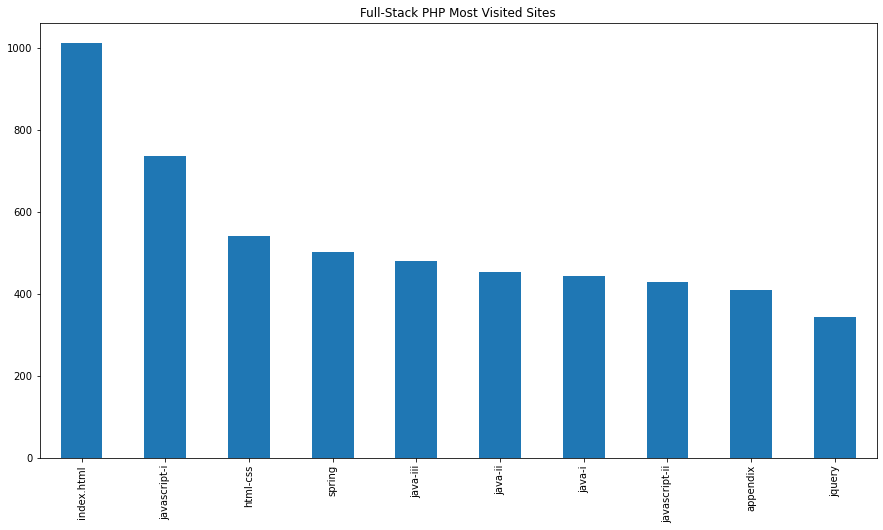

In [11]:
df_dw[df_dw['program_name'] == 'PHP Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack PHP Most Visited Sites', figsize = (15,8));

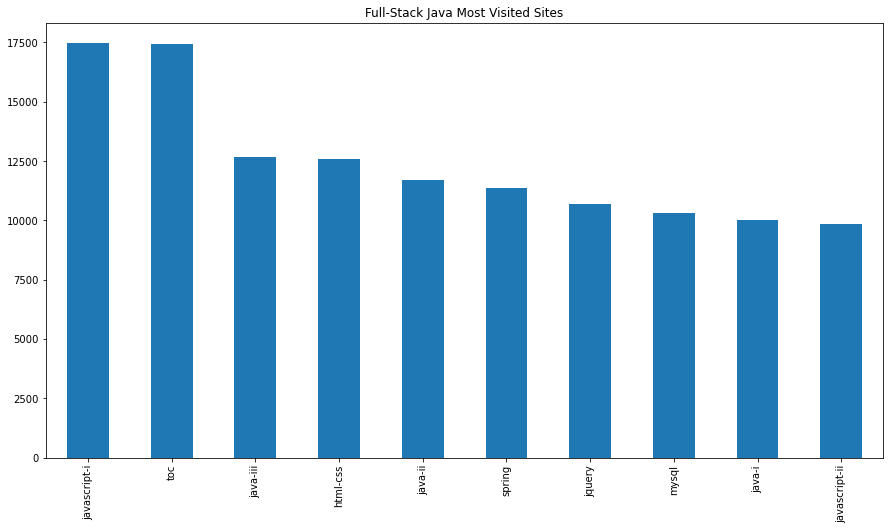

In [12]:
df_dw[df_dw['program_name'] == 'Java Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack Java Most Visited Sites', figsize = (15,8));

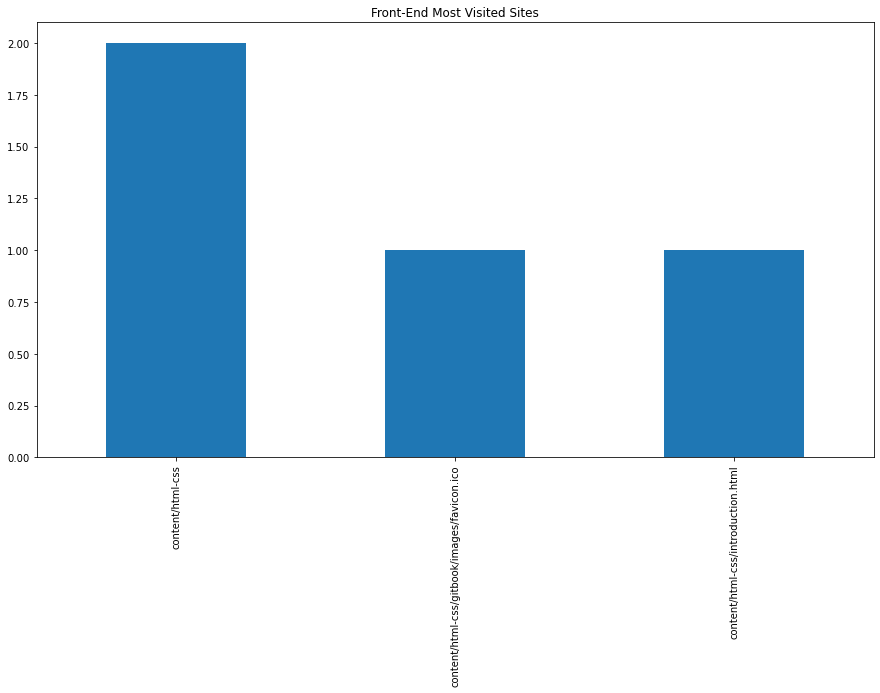

In [13]:
df_dw[df_dw['program_name'] == 'Front End Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Front-End Most Visited Sites', figsize = (15,8));

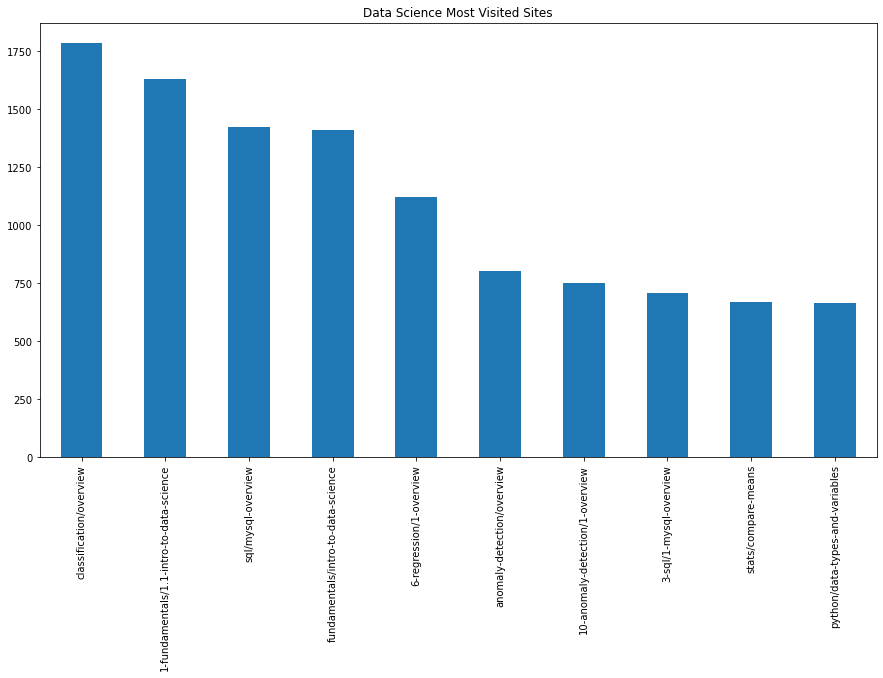

In [14]:
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited Sites', figsize = (15,8));

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

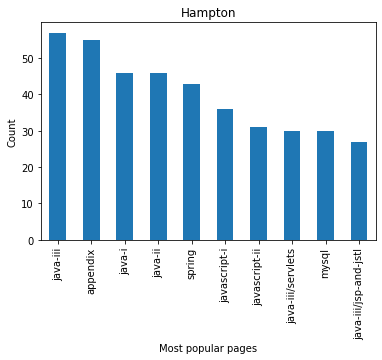

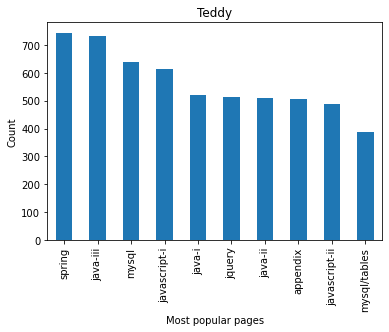

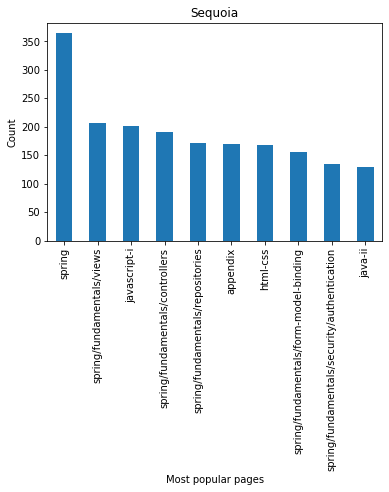

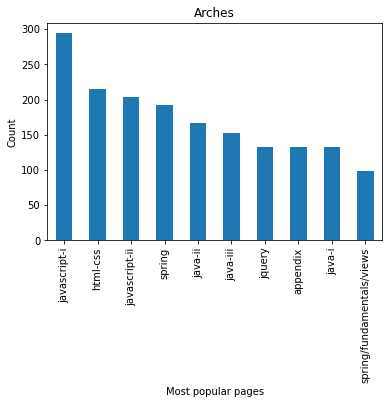

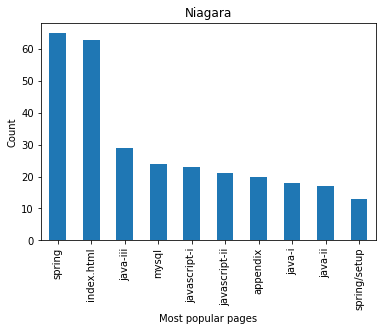

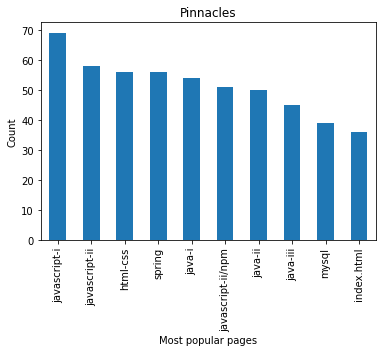

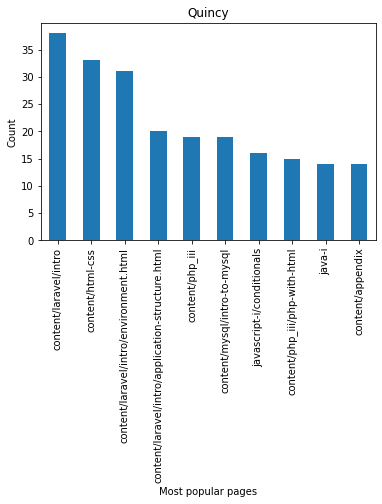

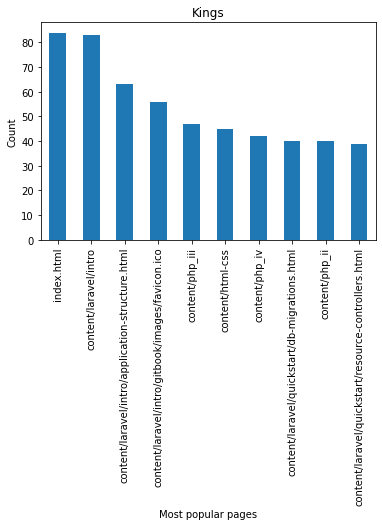

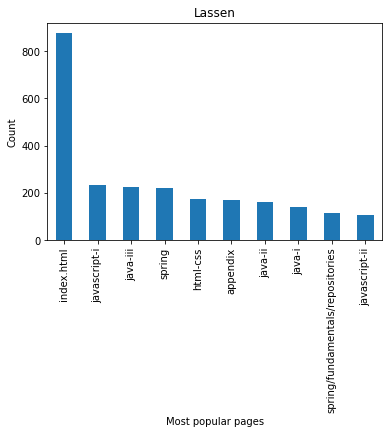

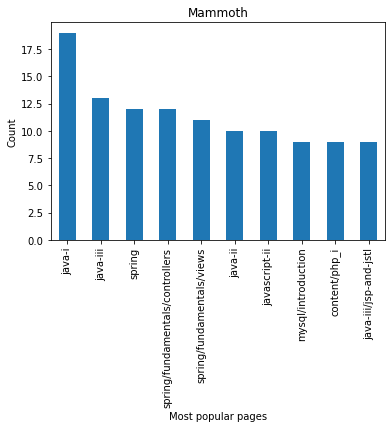

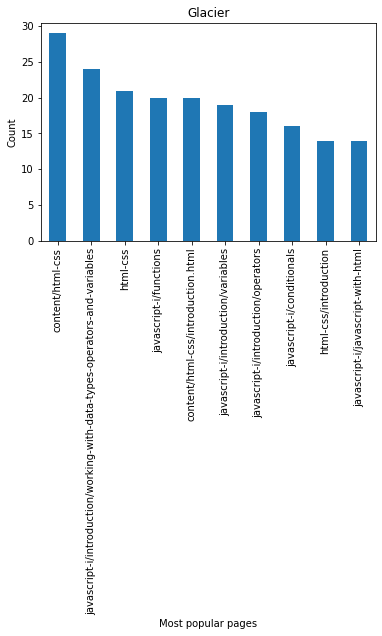

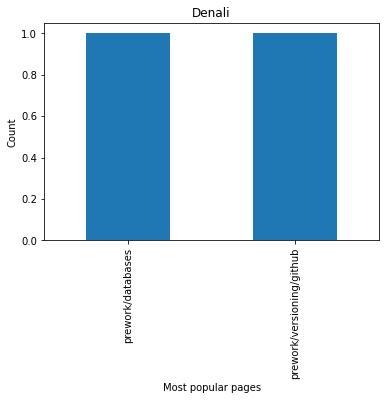

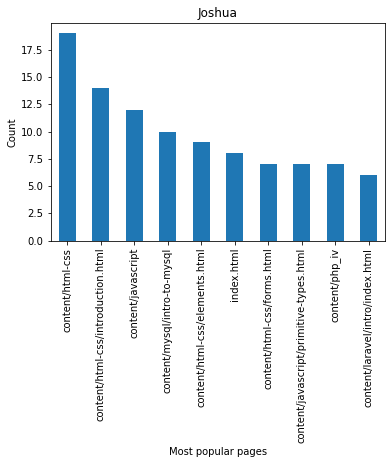

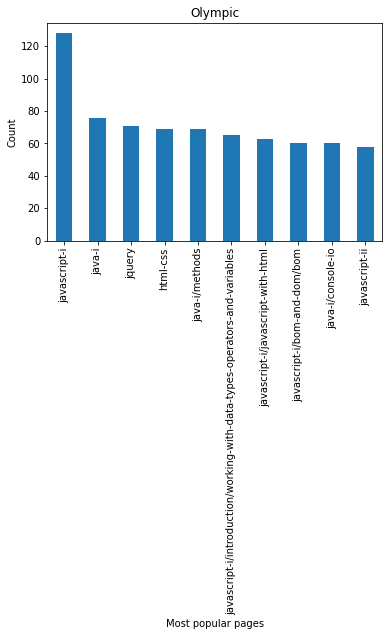

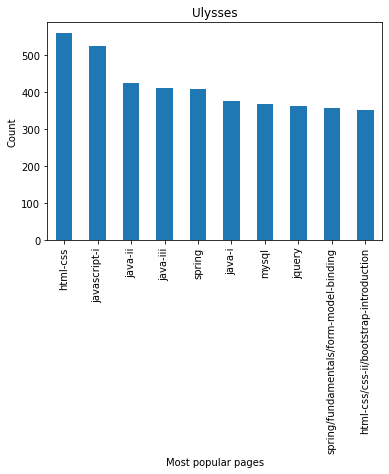

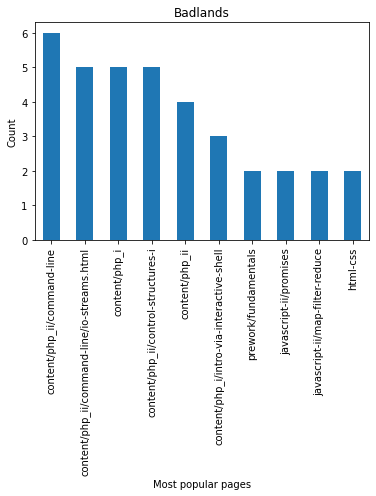

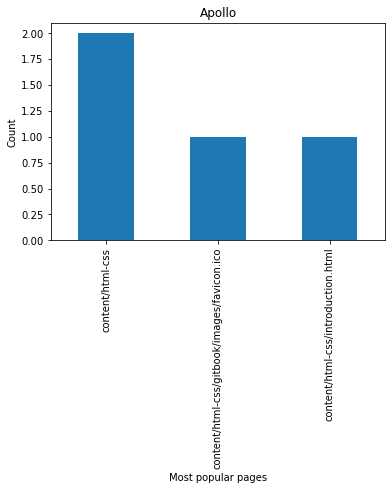

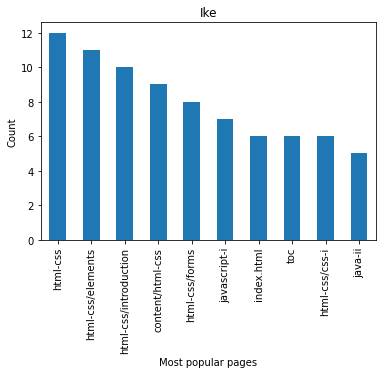

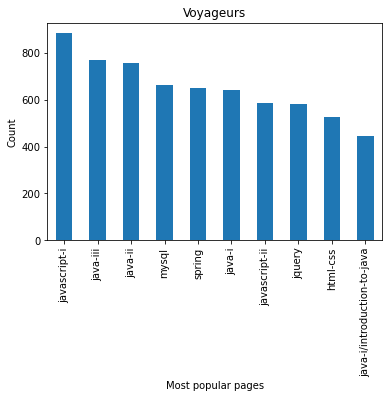

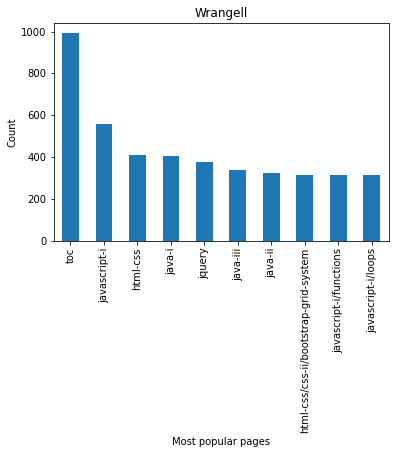

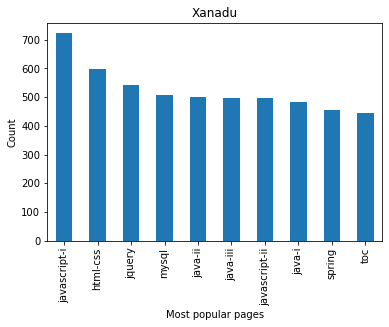

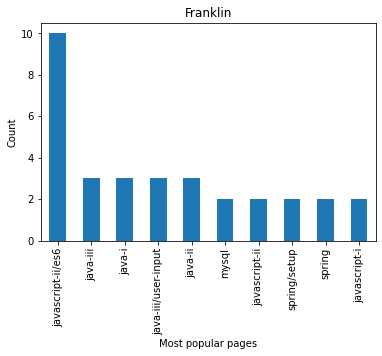

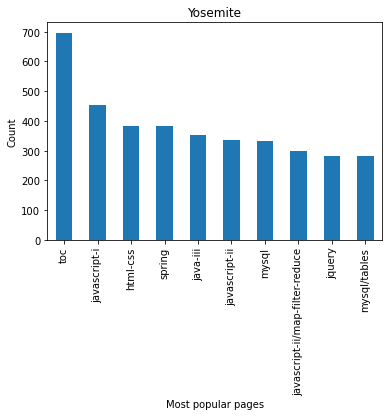

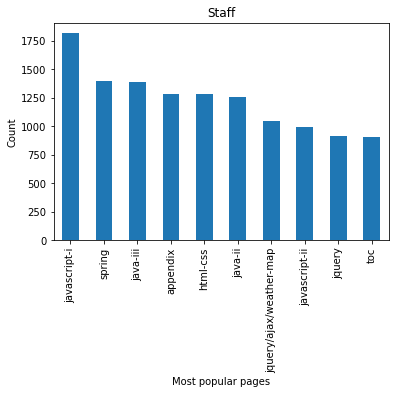

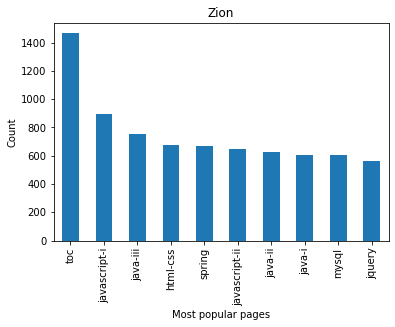

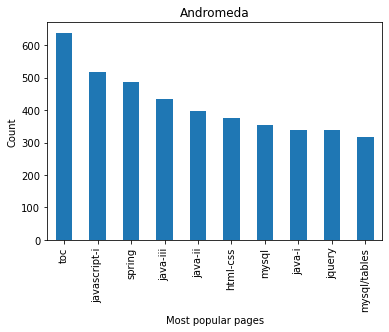

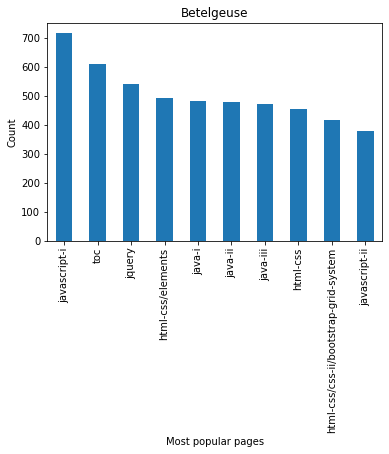

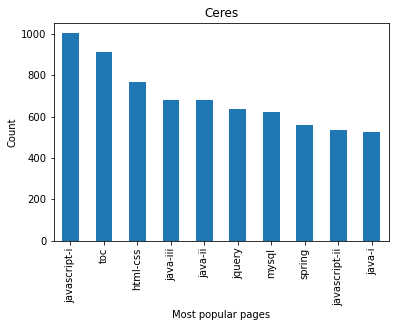

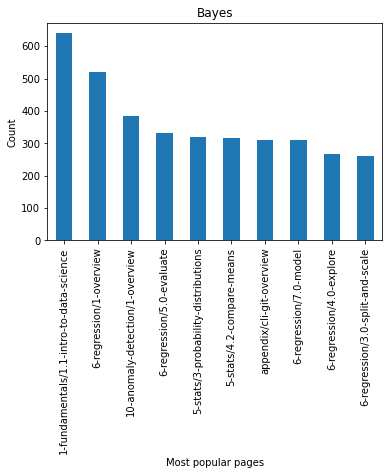

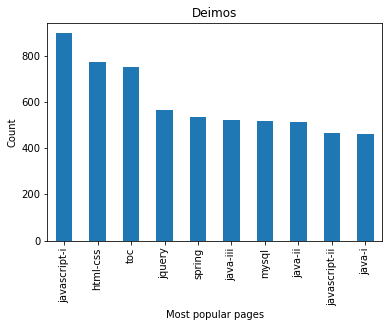

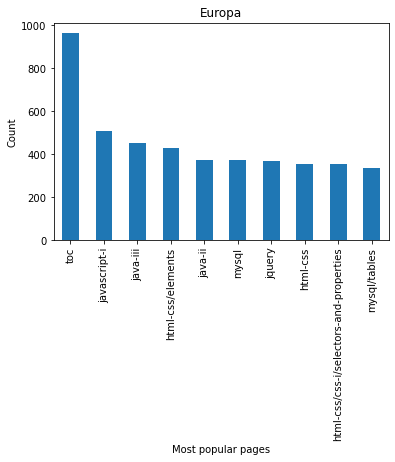

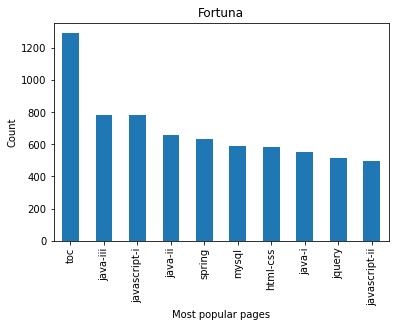

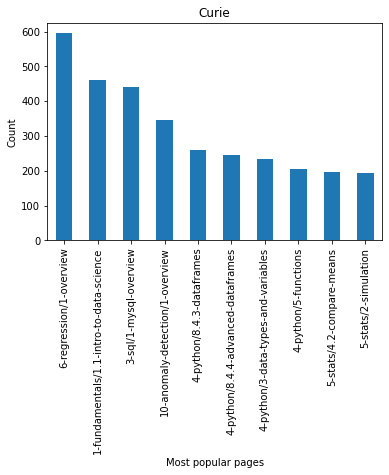

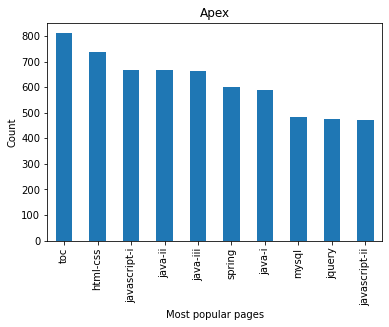

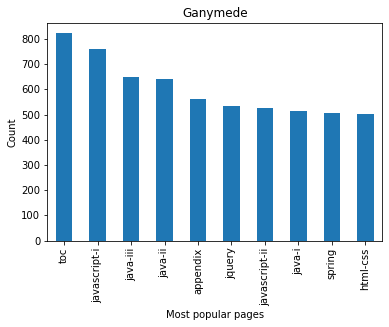

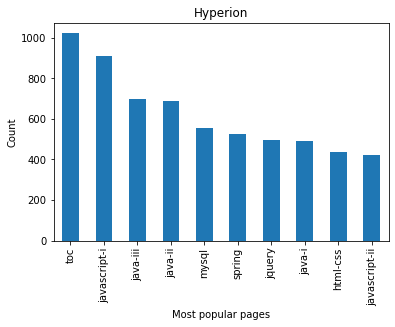

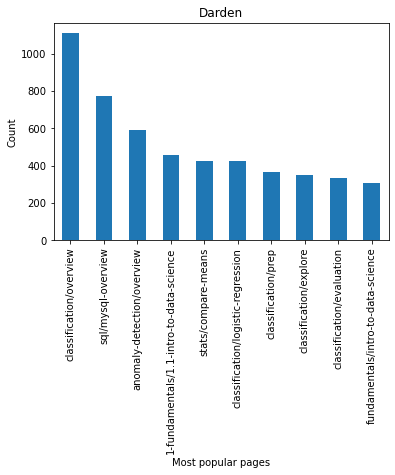

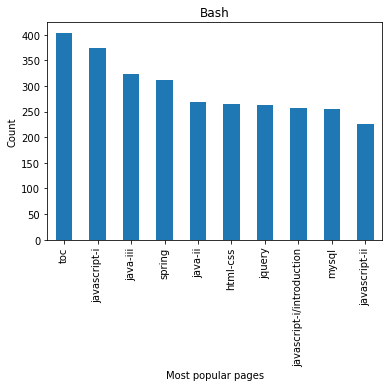

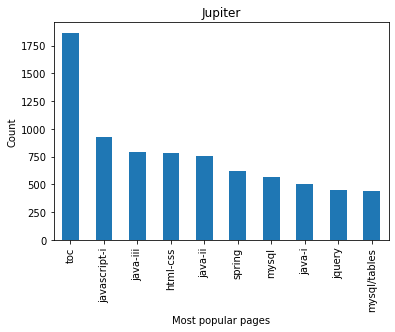

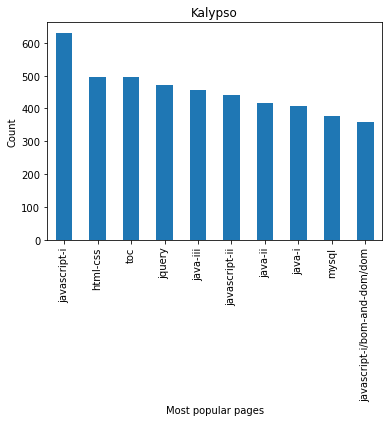

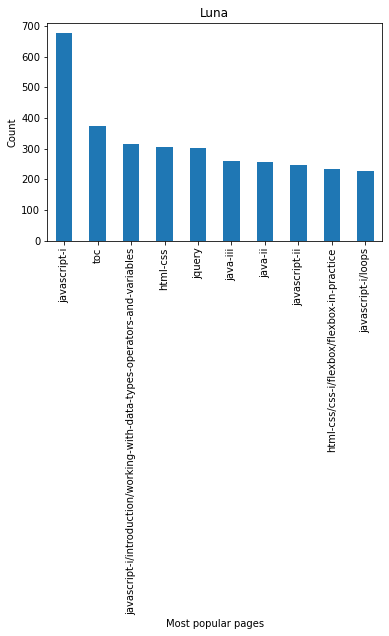

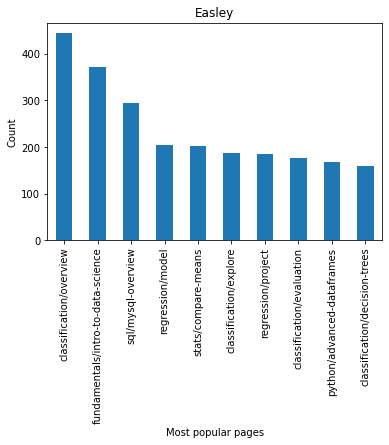

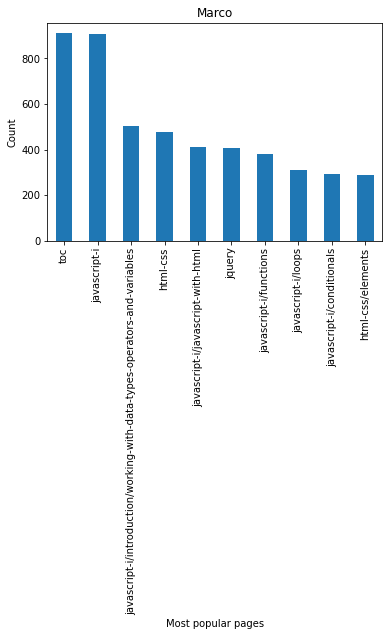

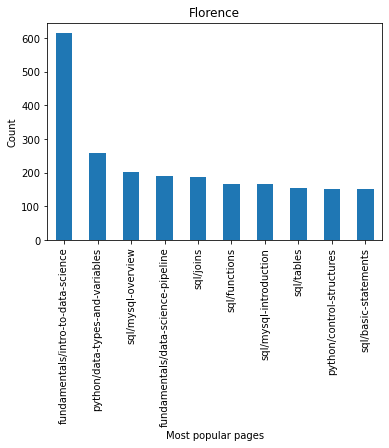

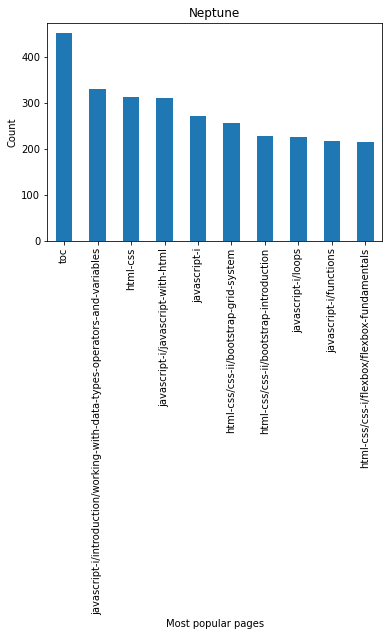

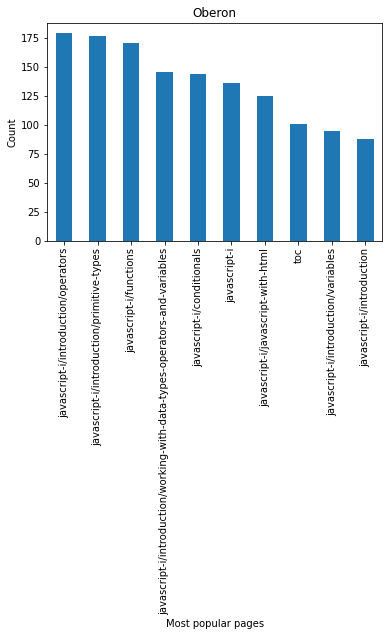

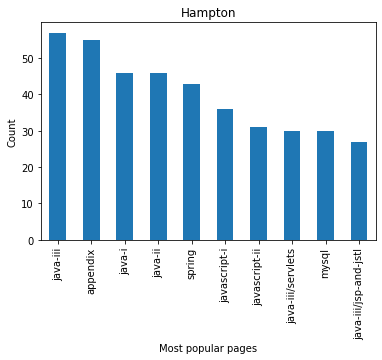

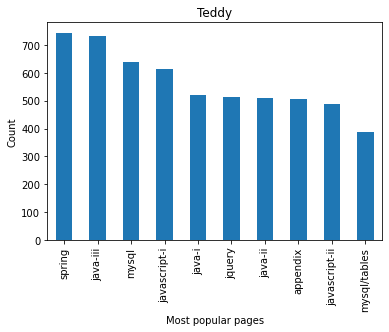

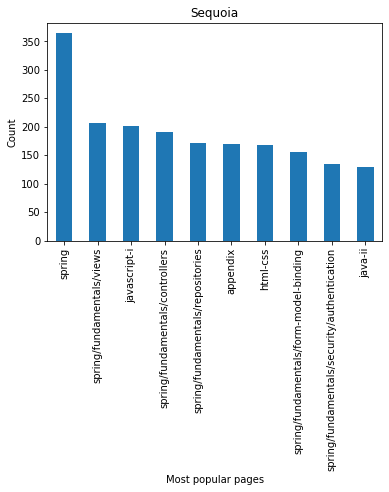

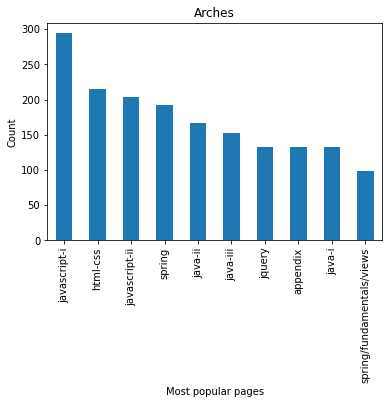

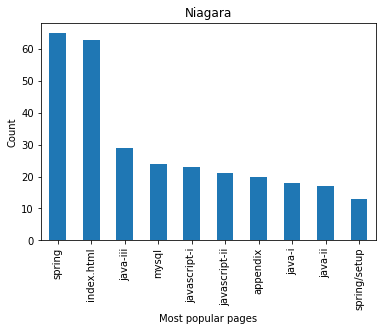

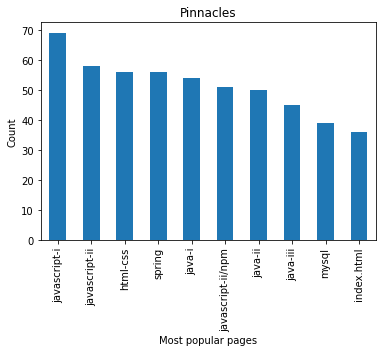

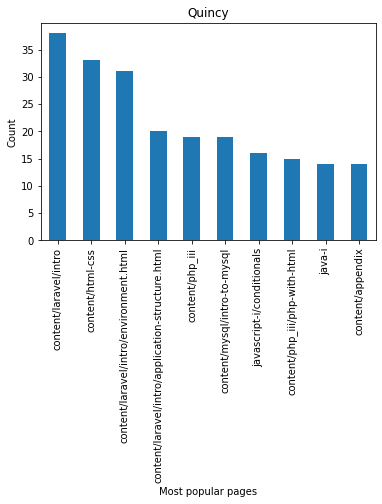

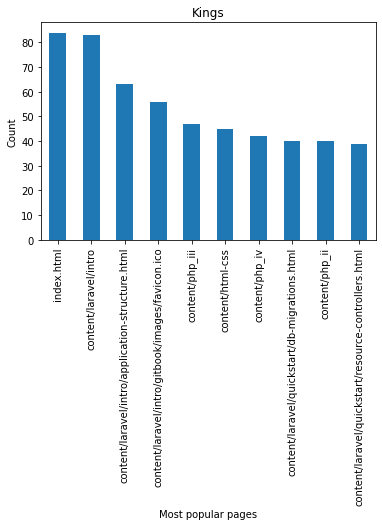

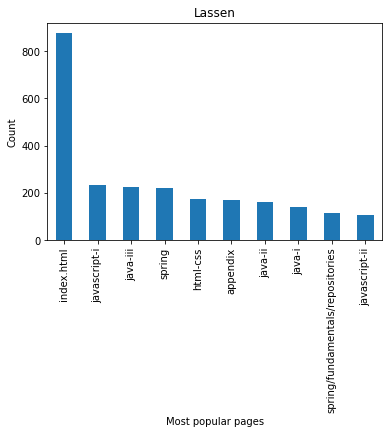

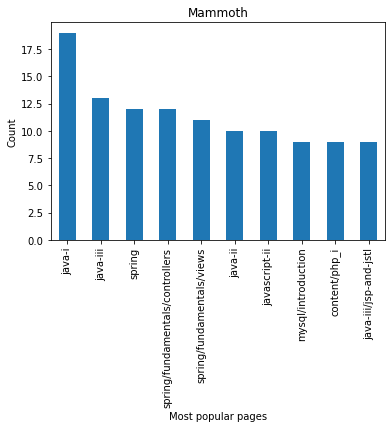

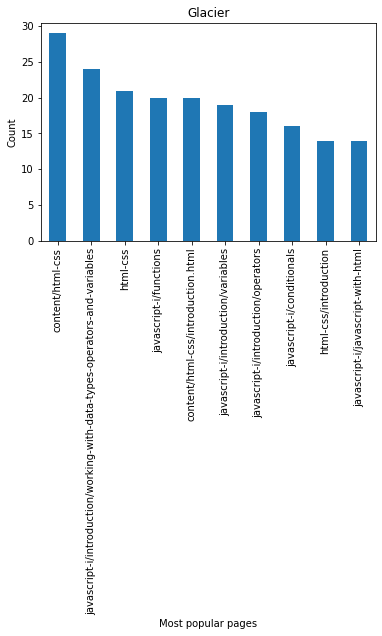

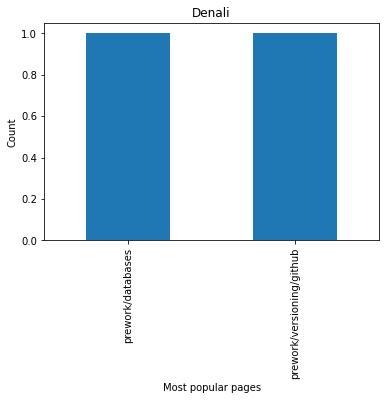

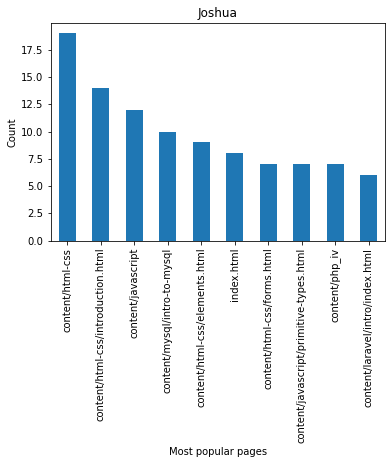

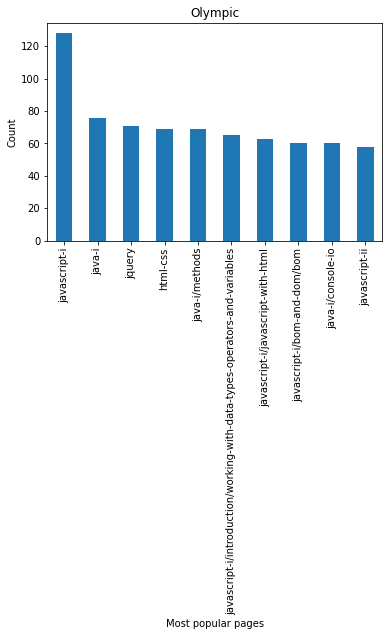

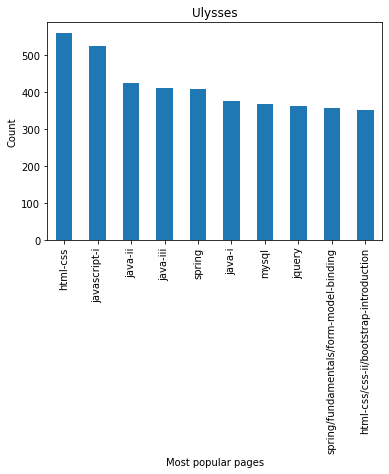

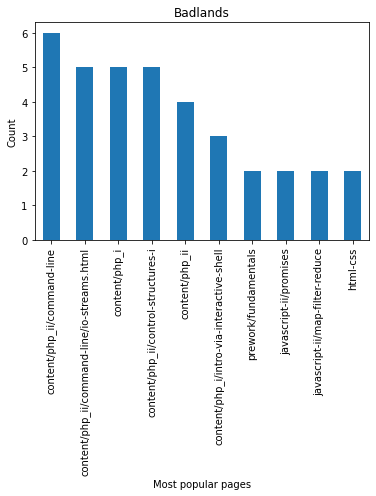

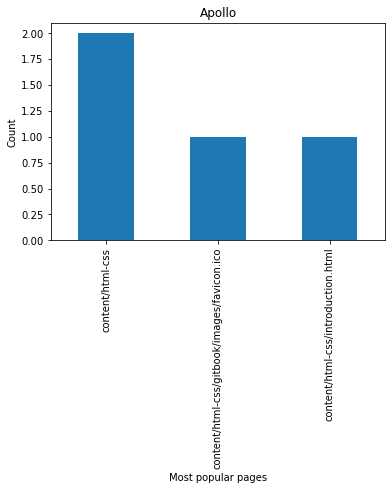

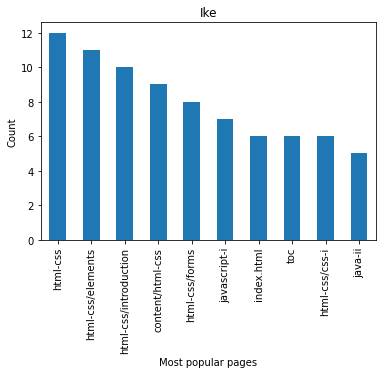

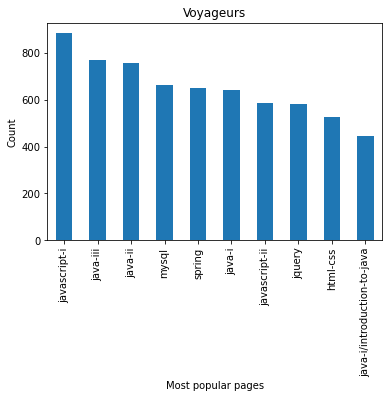

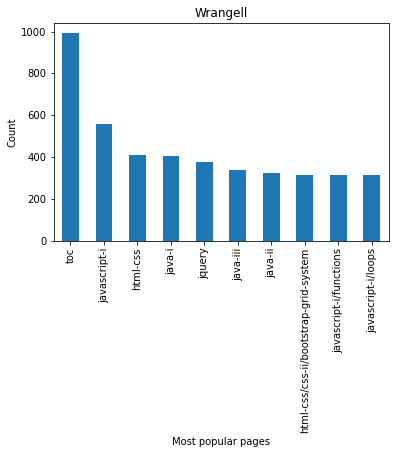

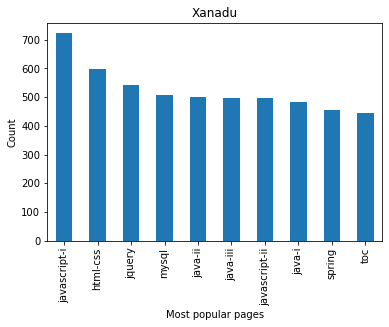

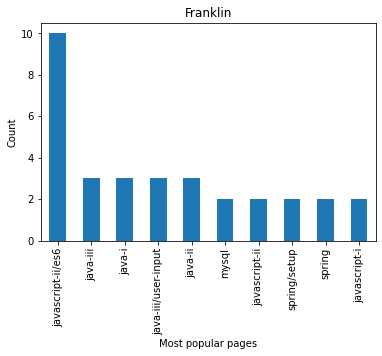

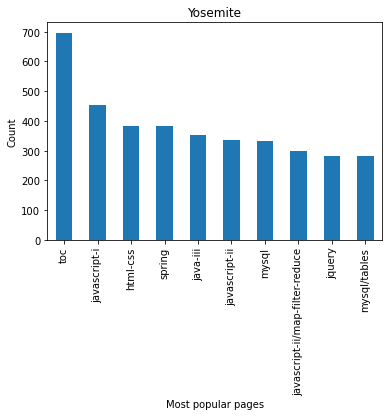

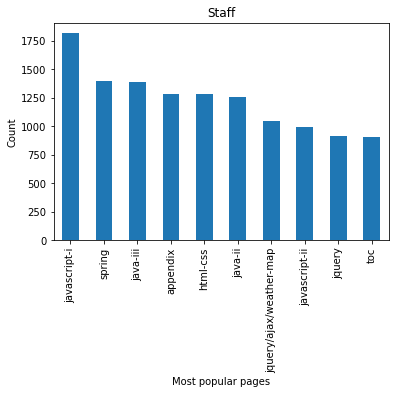

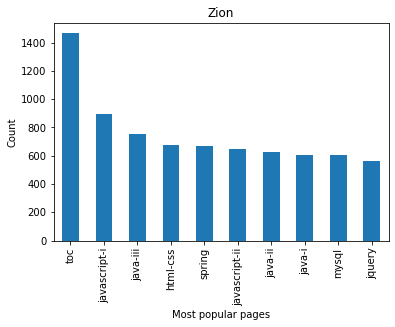

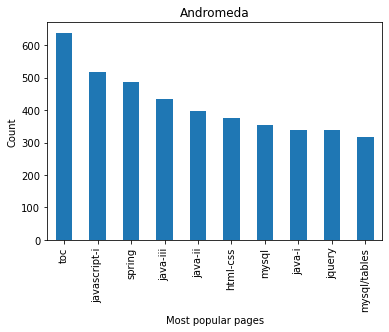

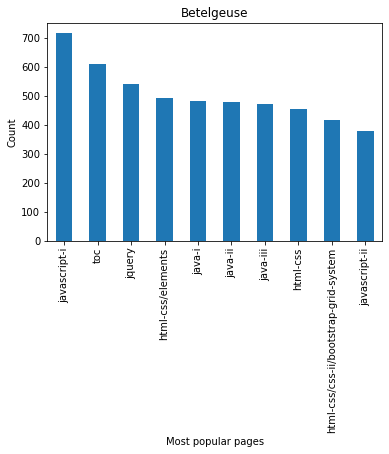

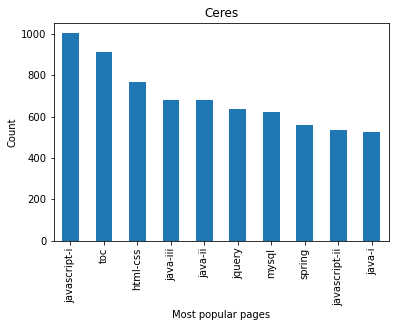

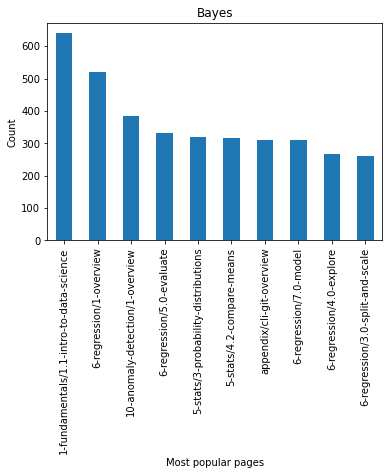

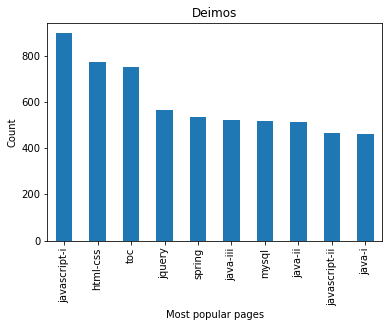

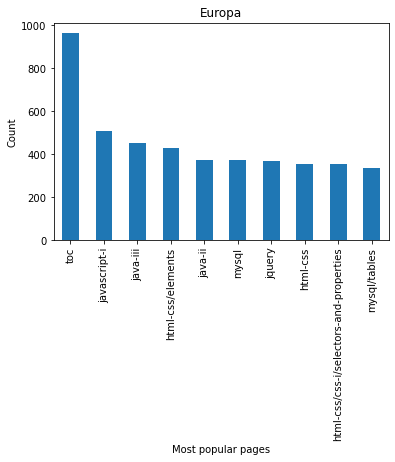

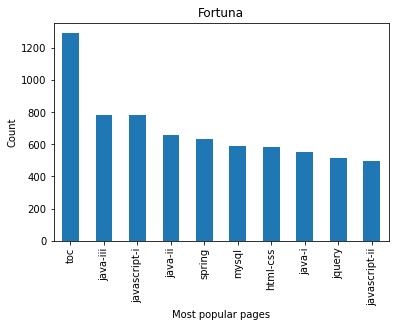

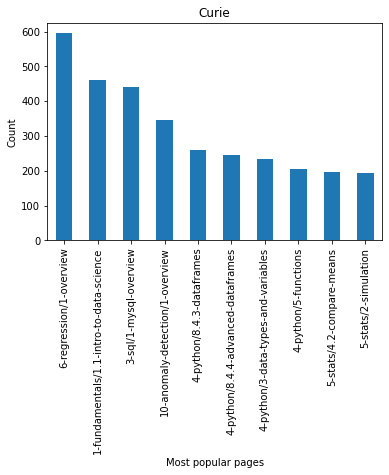

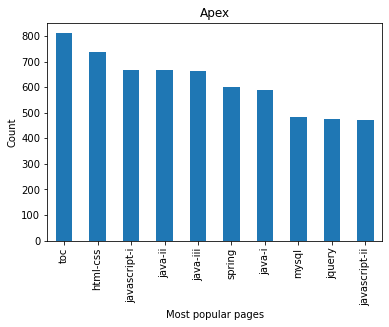

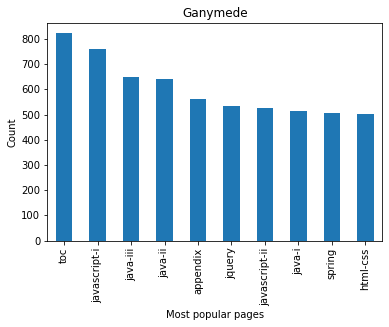

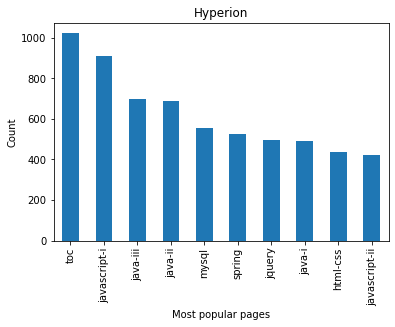

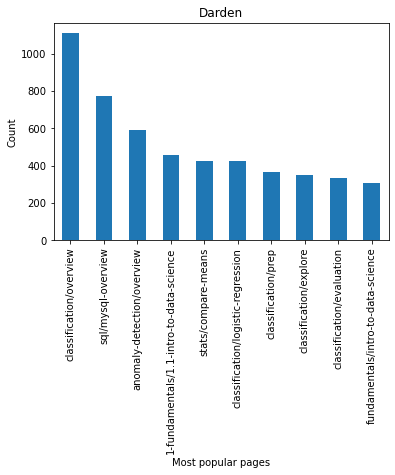

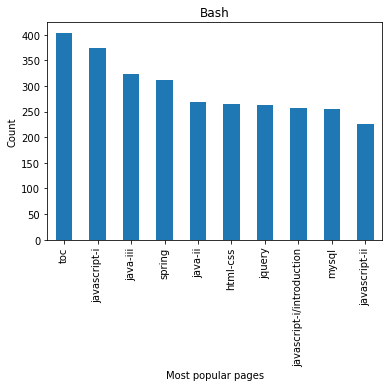

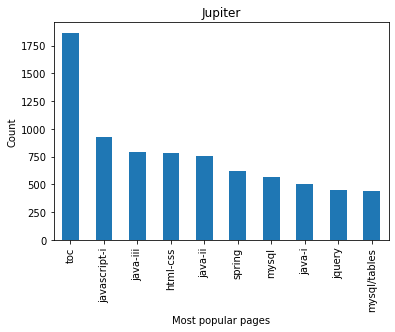

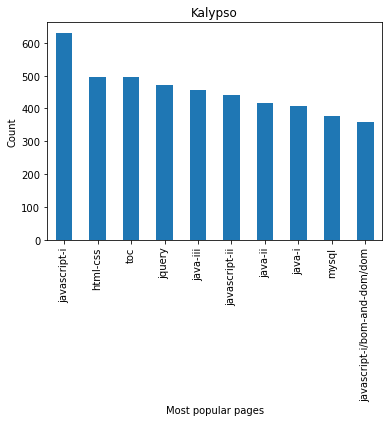

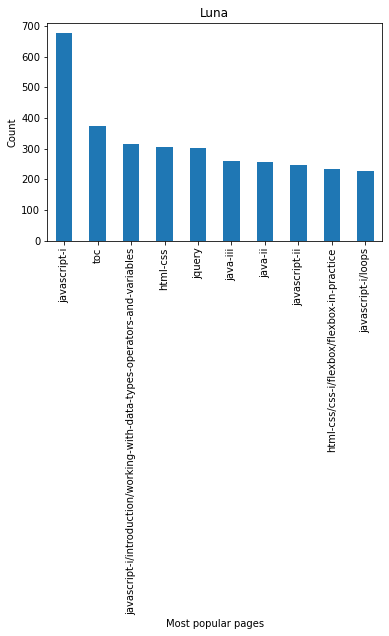

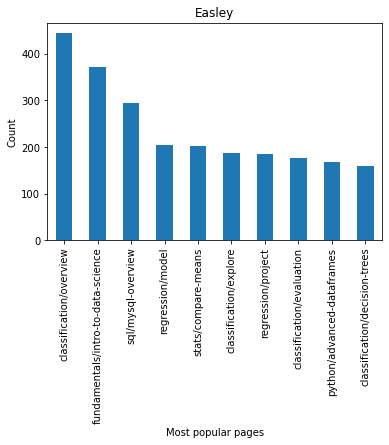

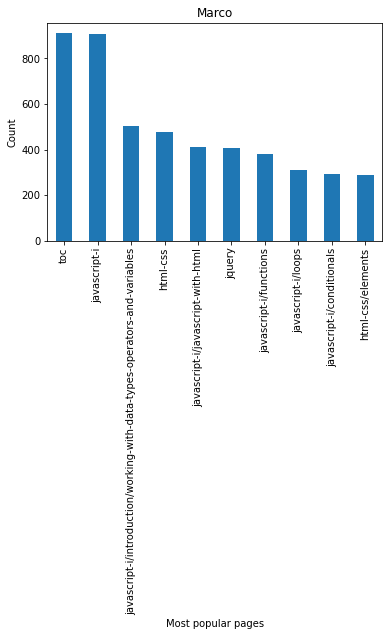

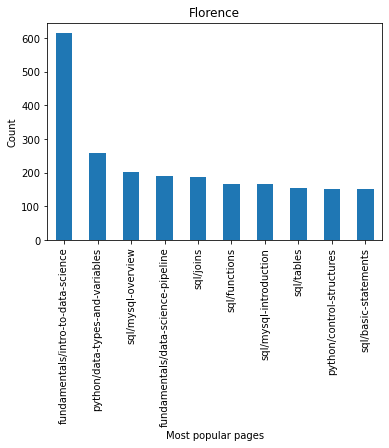

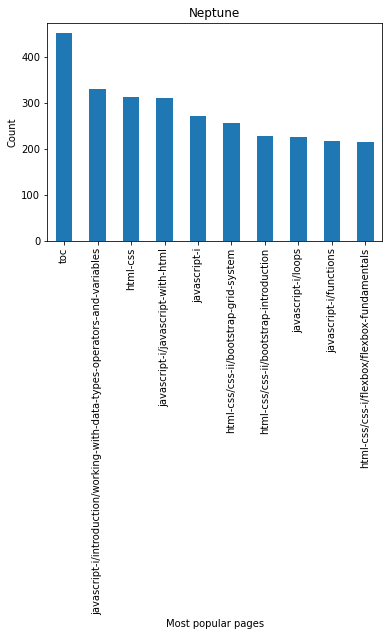

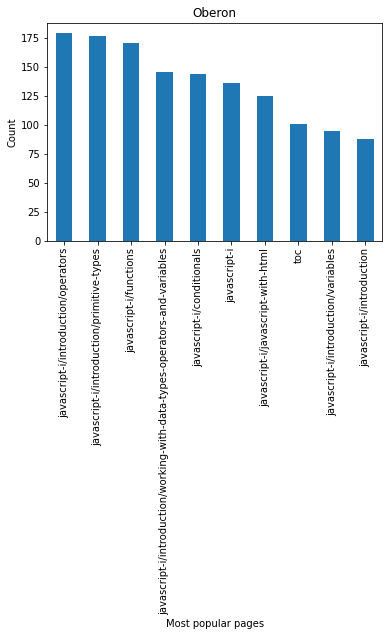

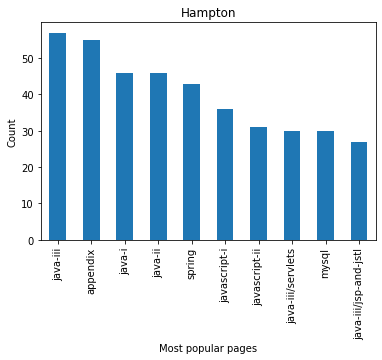

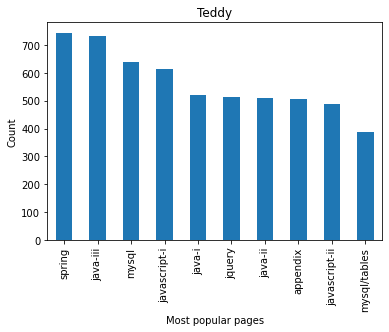

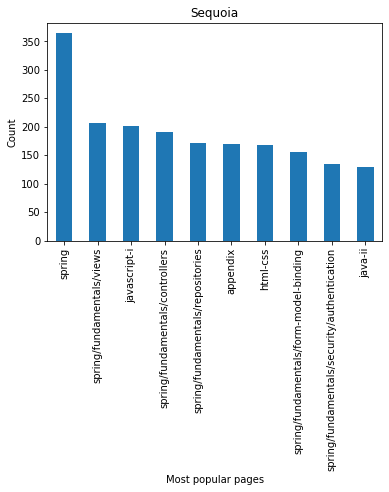

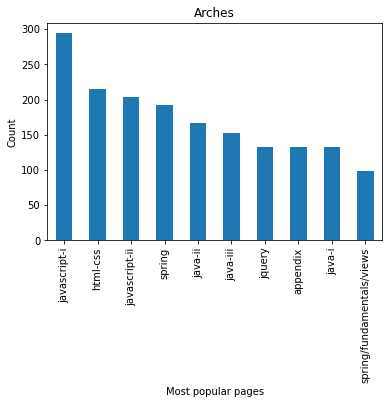

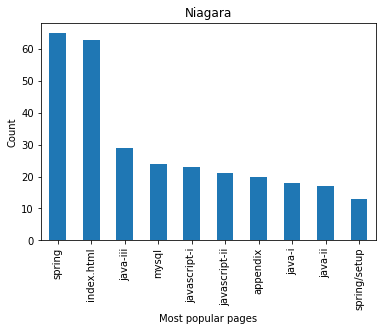

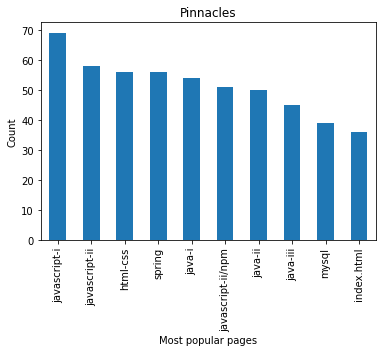

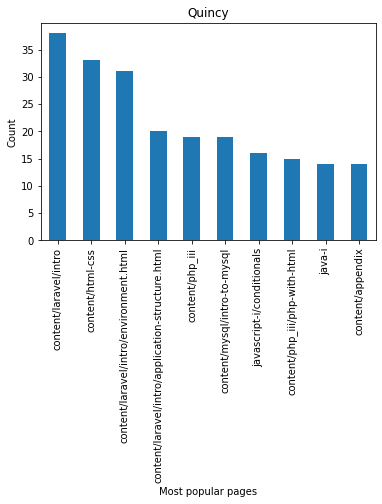

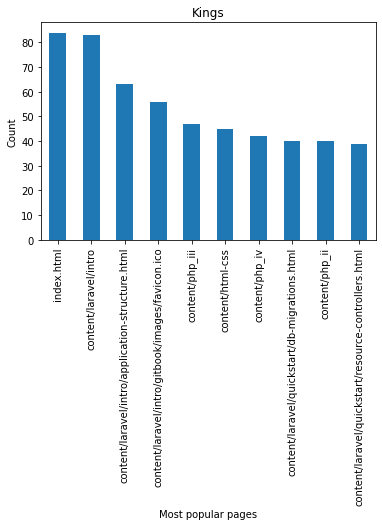

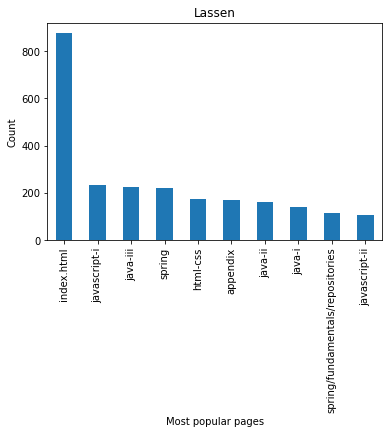

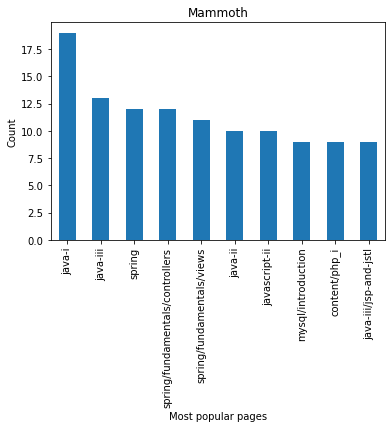

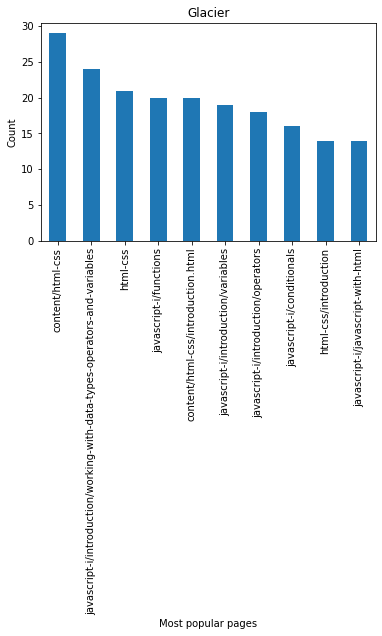

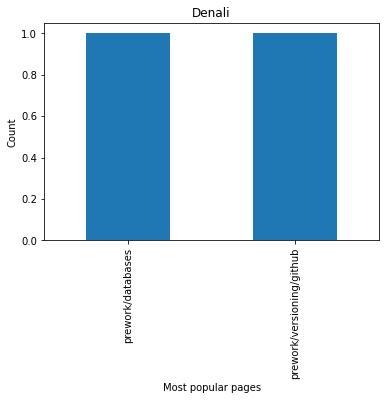

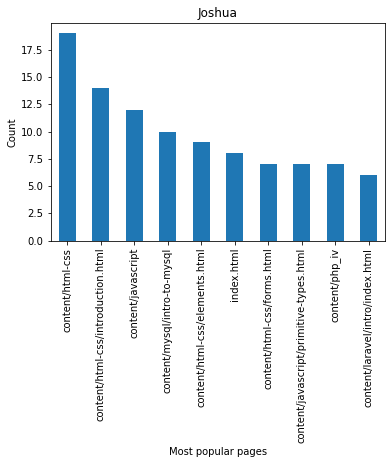

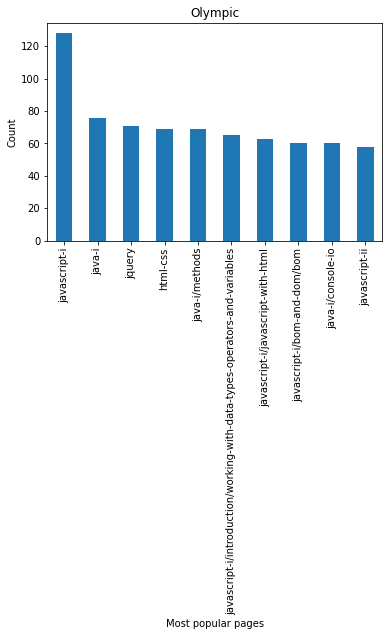

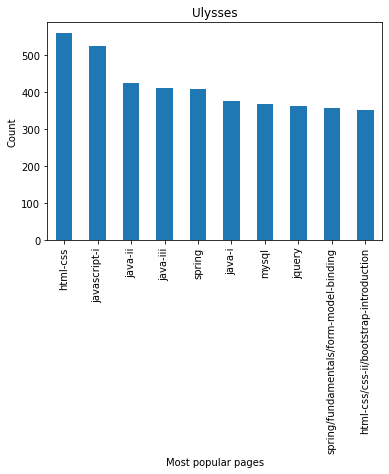

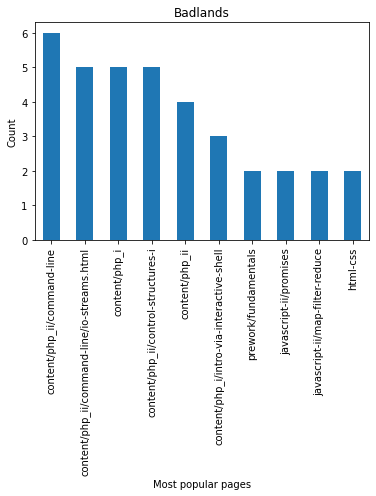

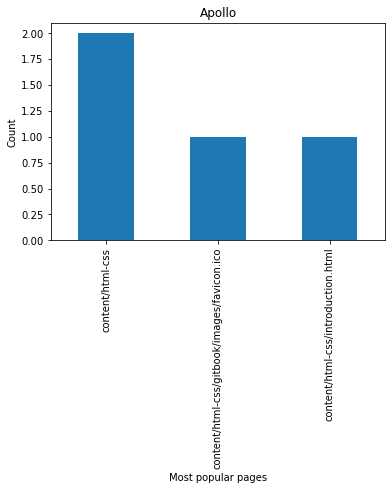

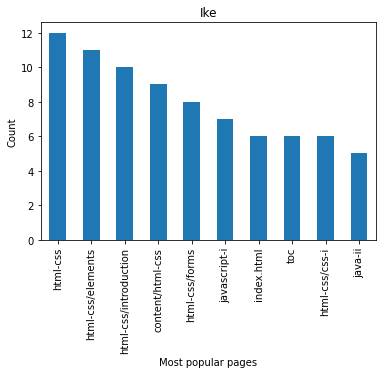

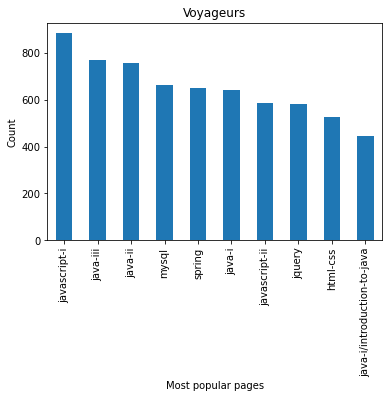

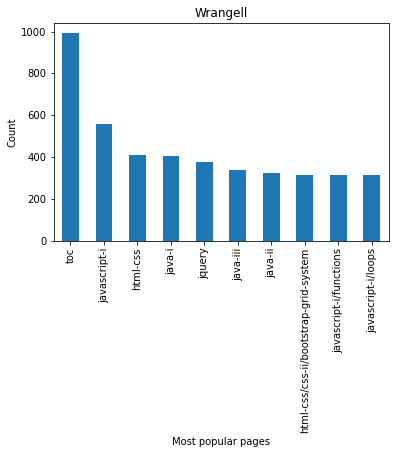

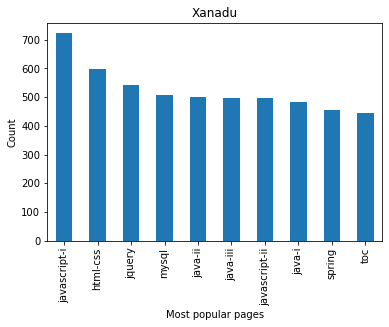

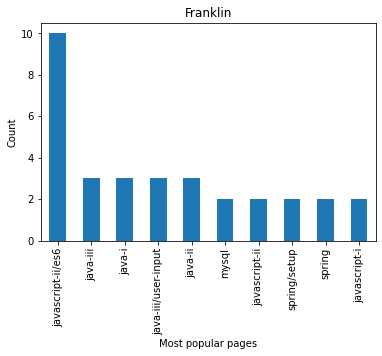

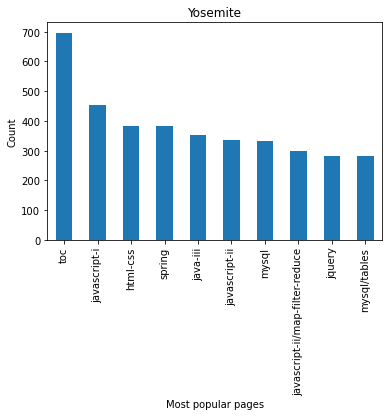

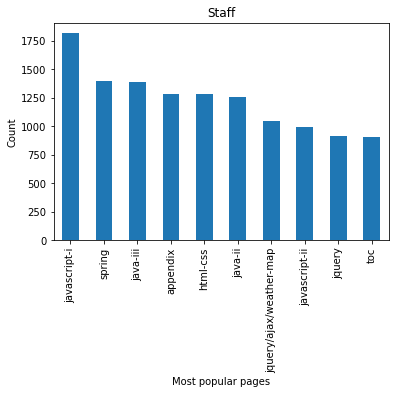

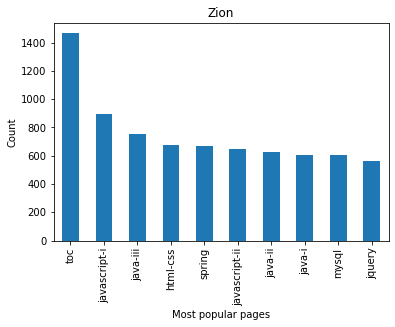

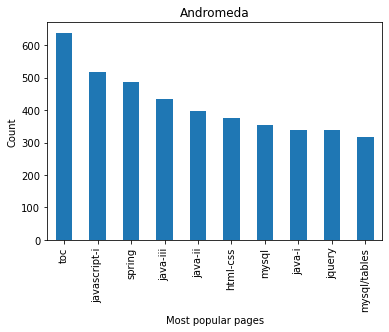

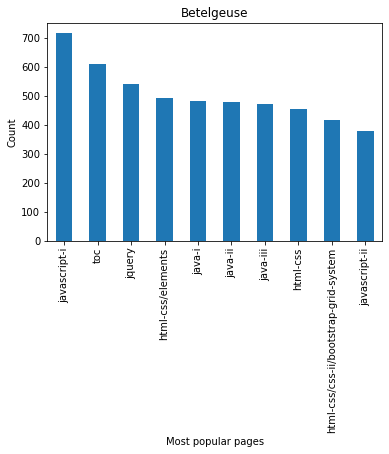

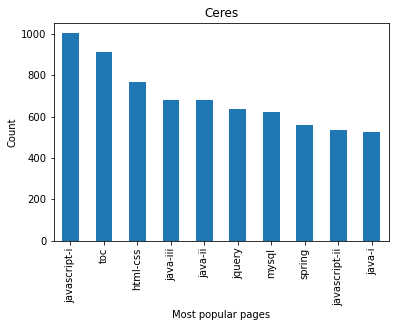

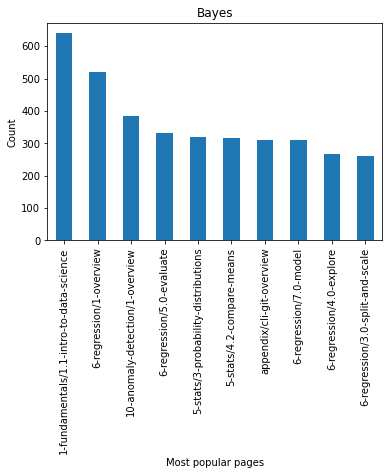

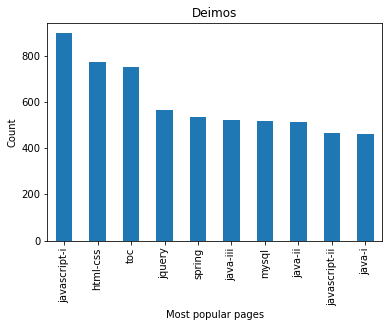

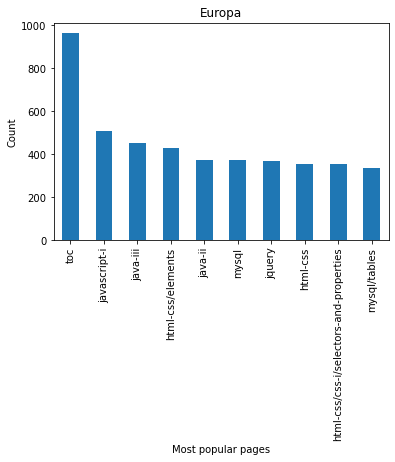

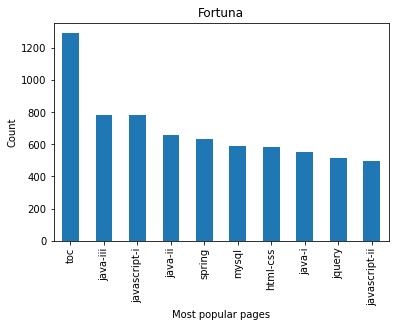

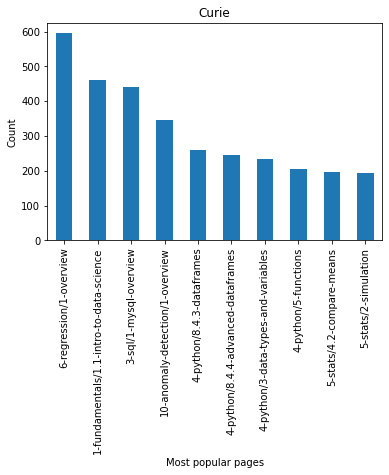

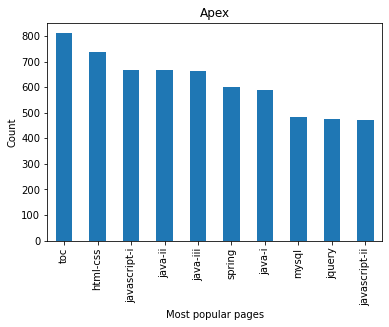

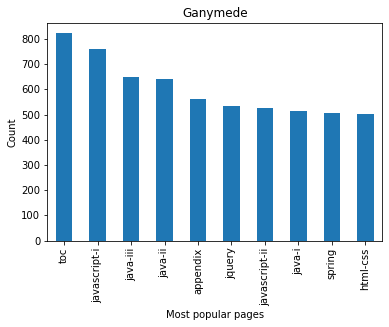

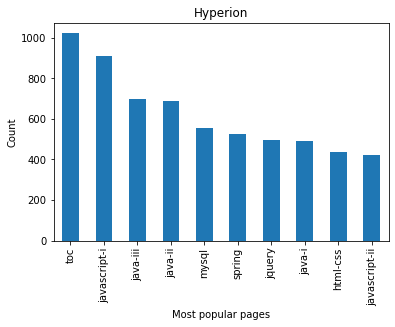

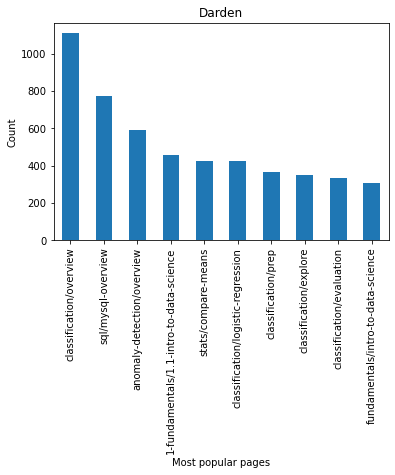

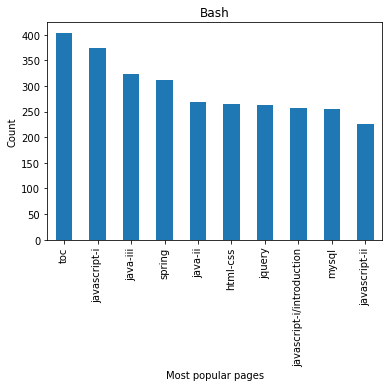

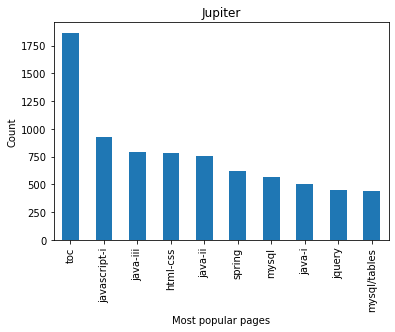

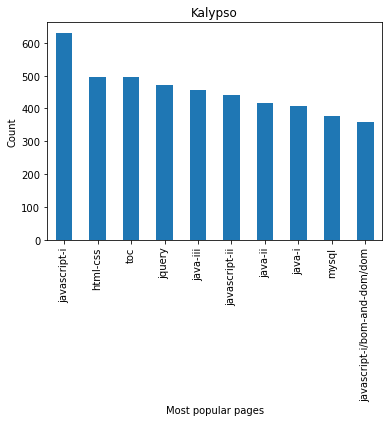

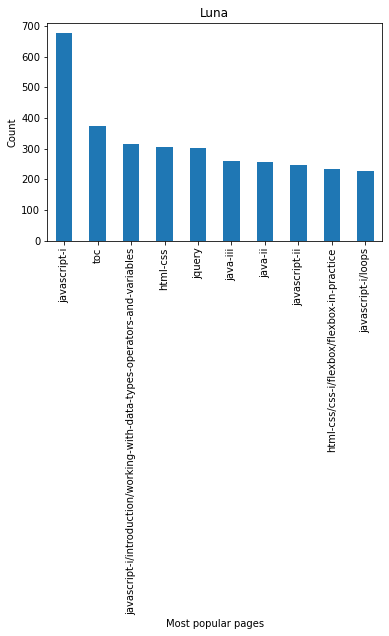

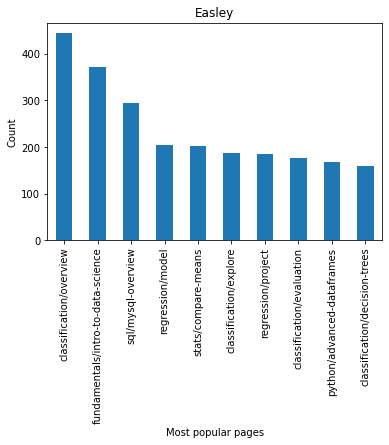

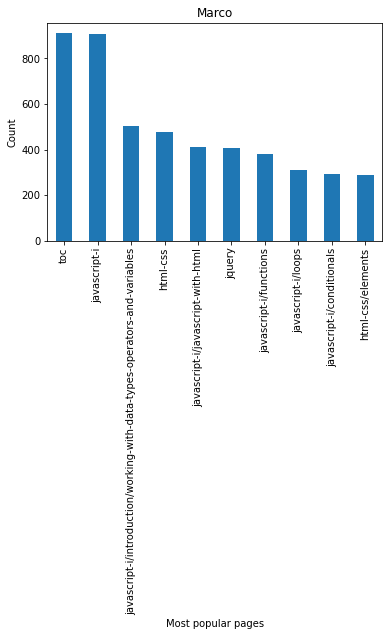

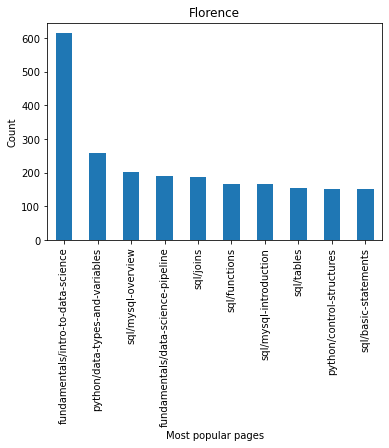

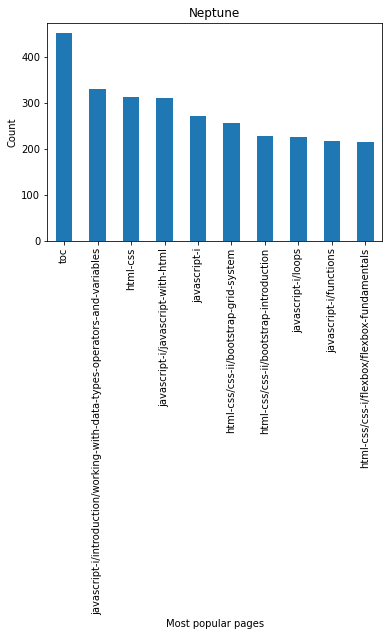

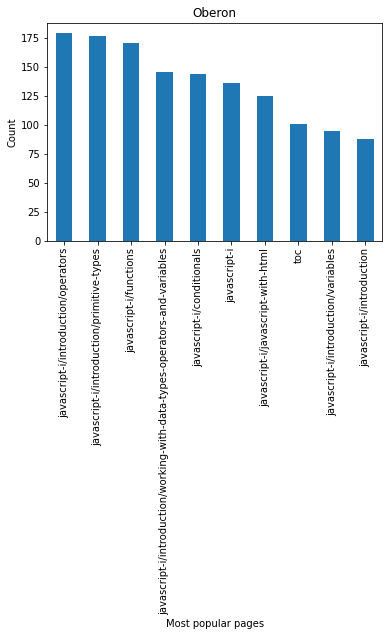

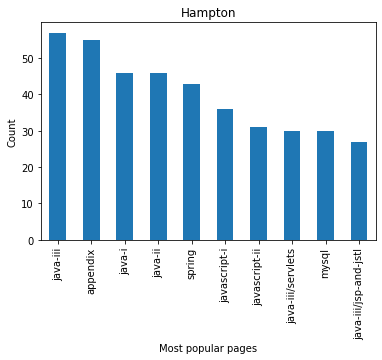

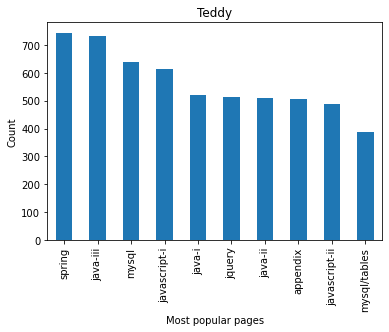

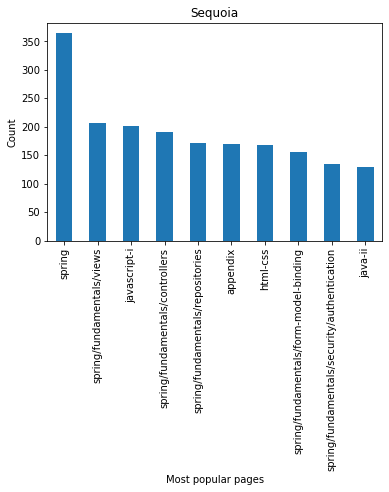

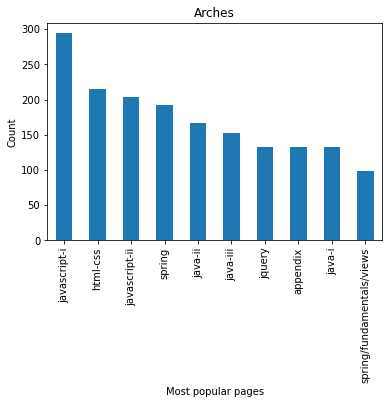

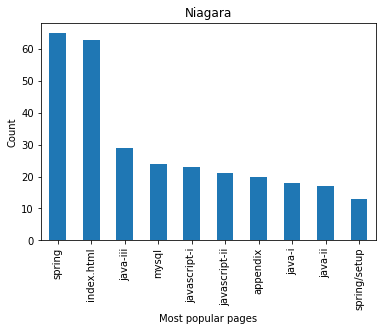

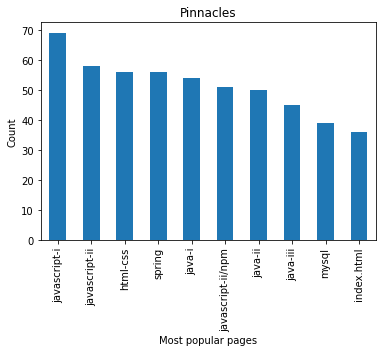

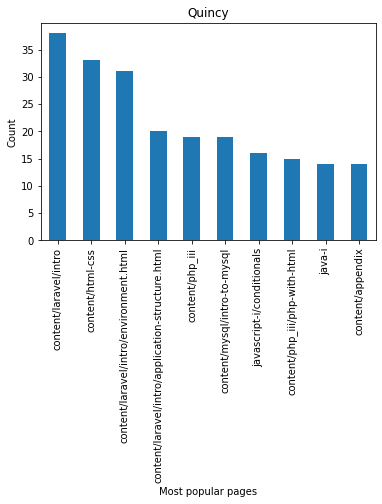

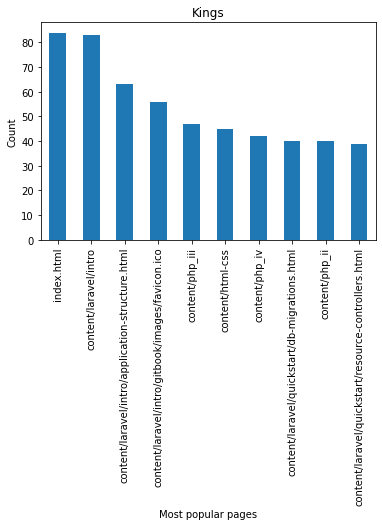

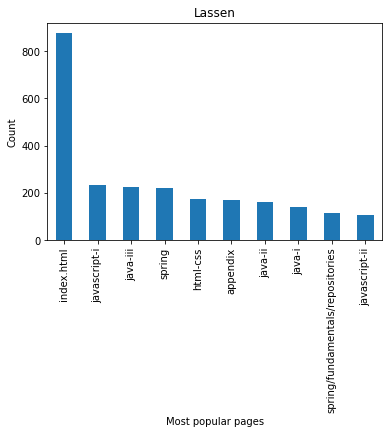

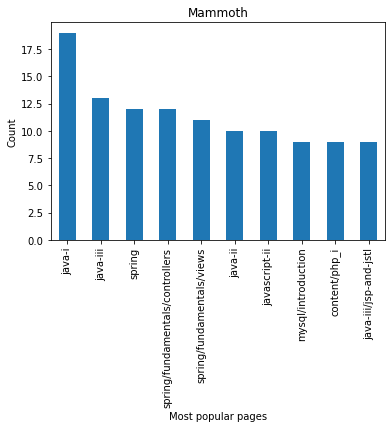

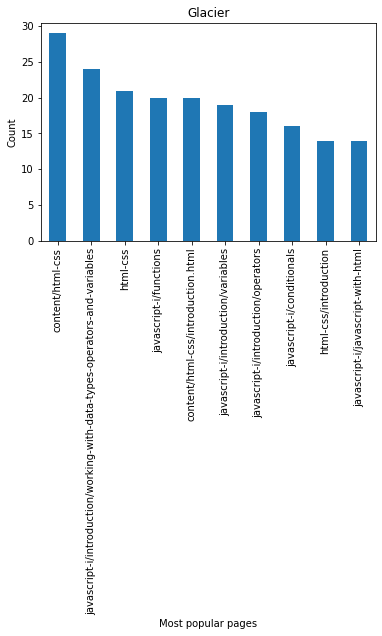

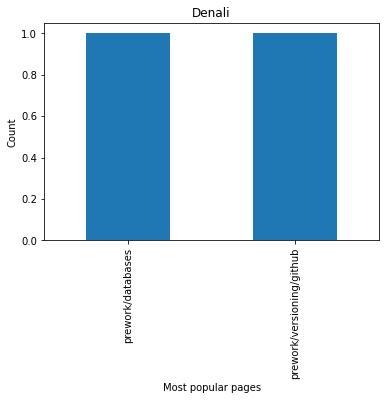

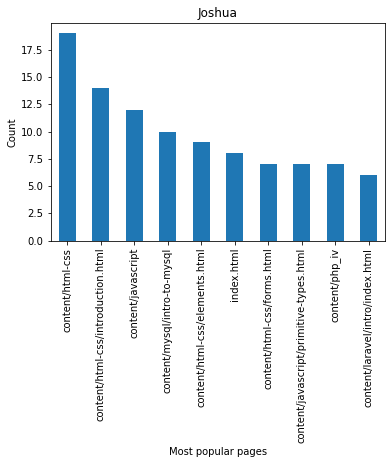

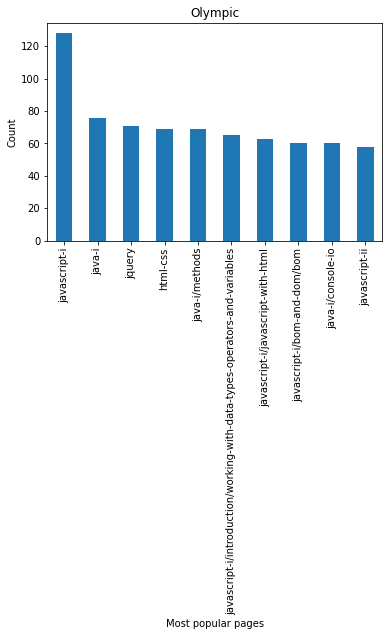

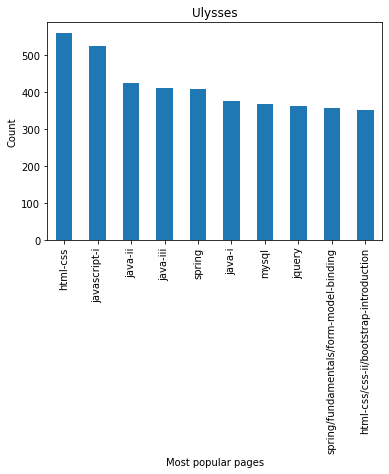

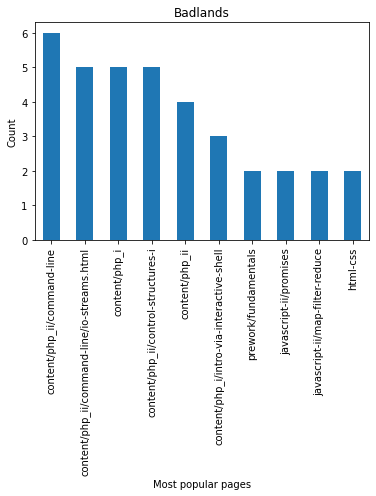

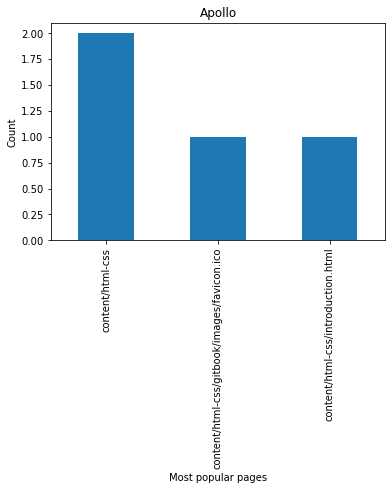

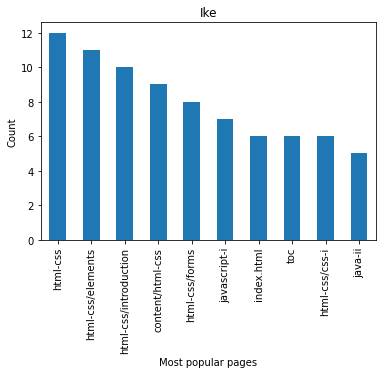

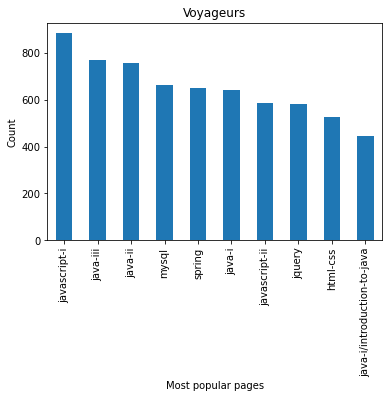

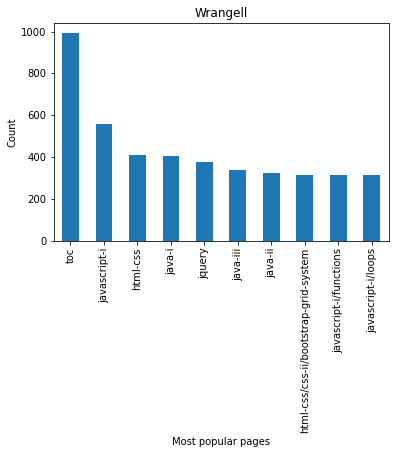

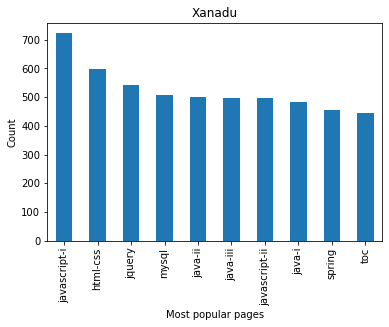

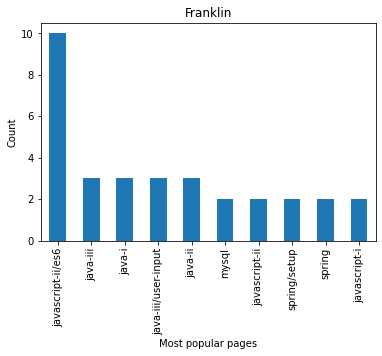

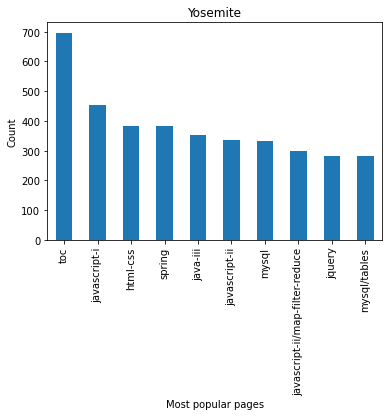

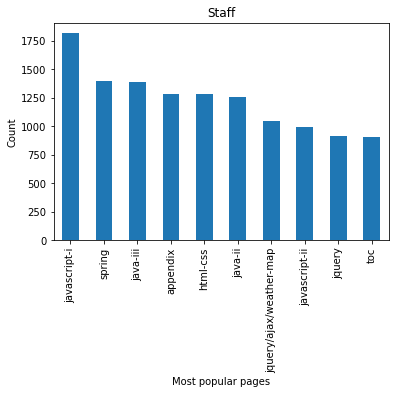

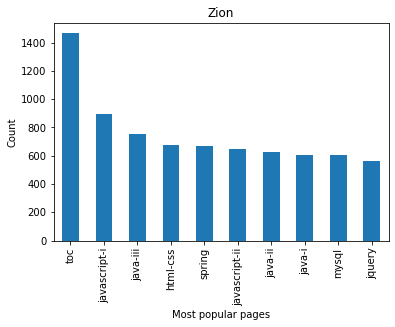

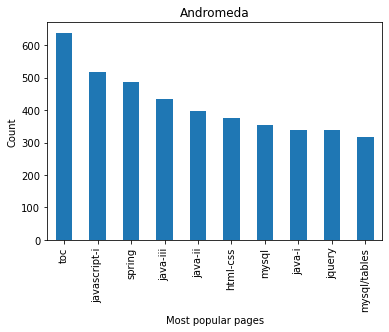

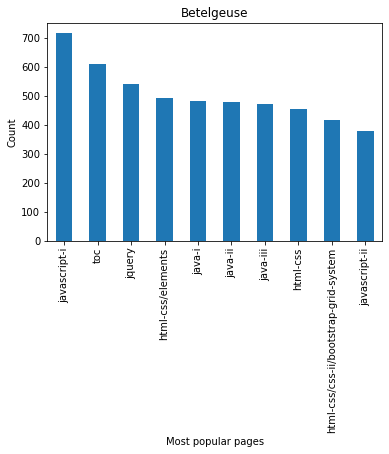

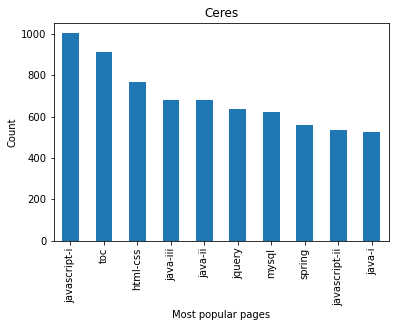

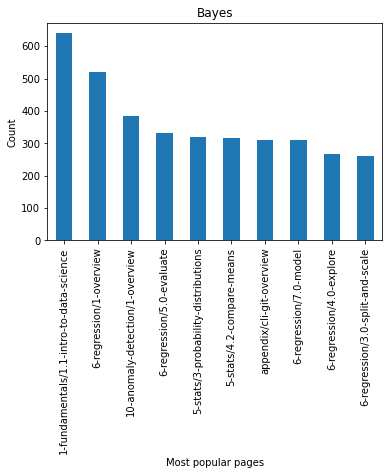

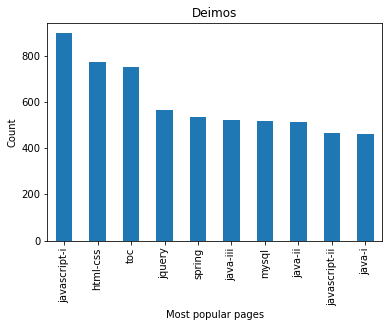

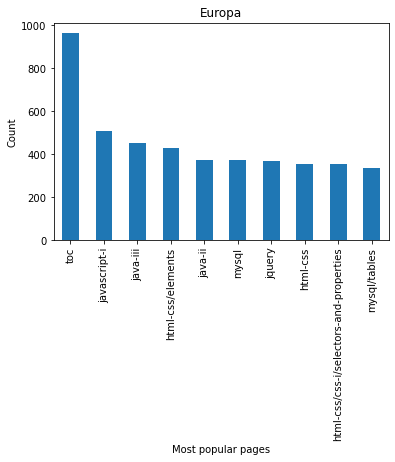

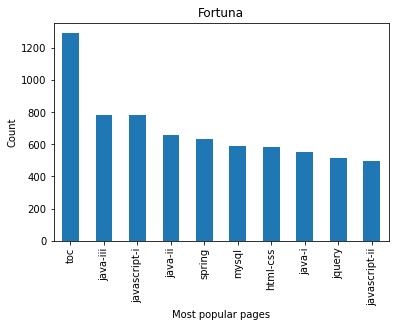

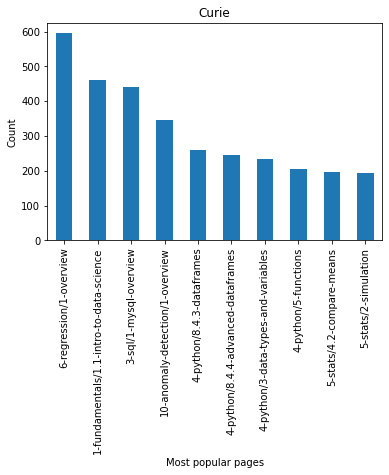

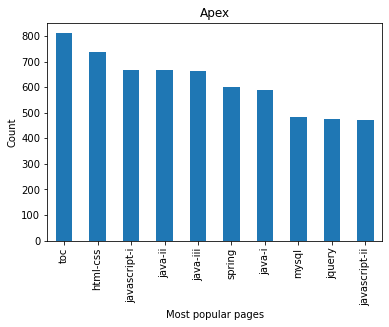

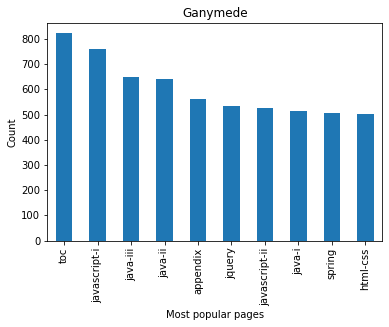

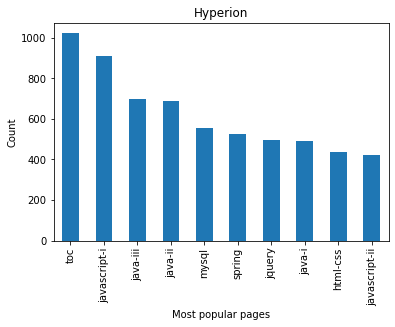

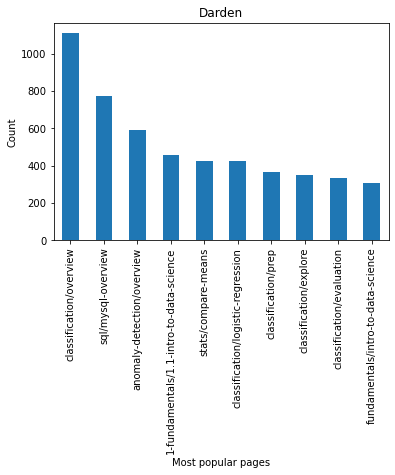

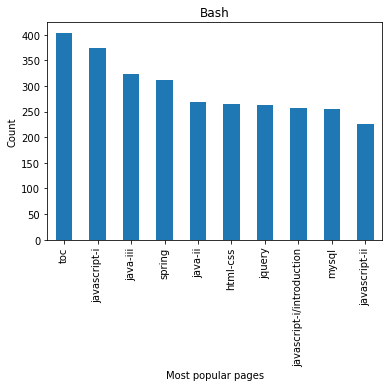

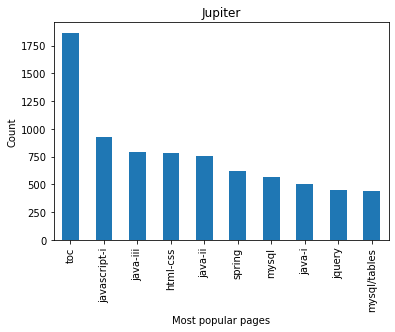

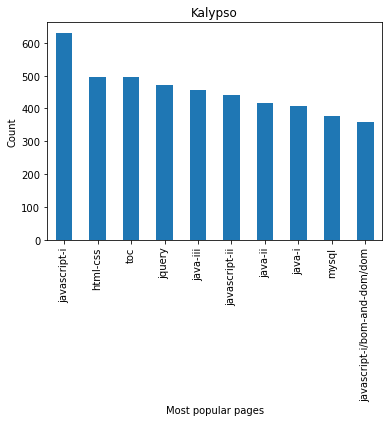

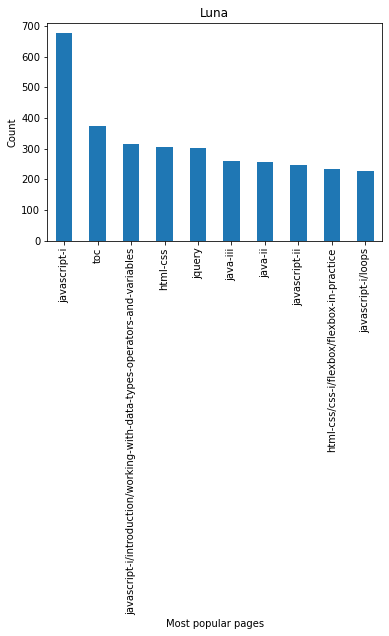

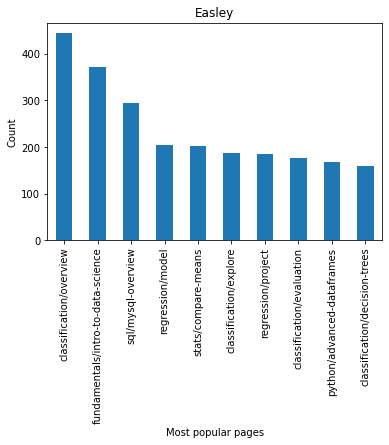

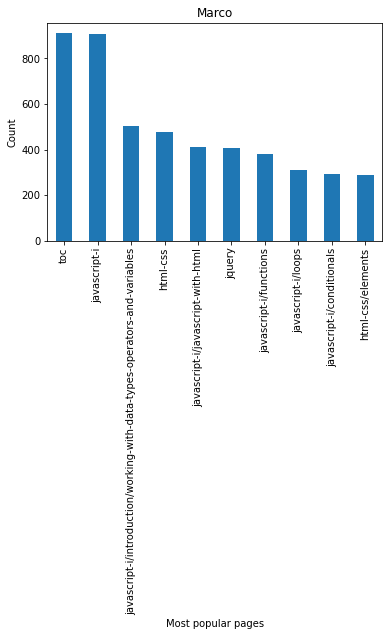

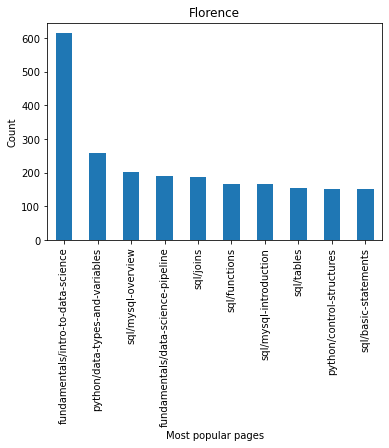

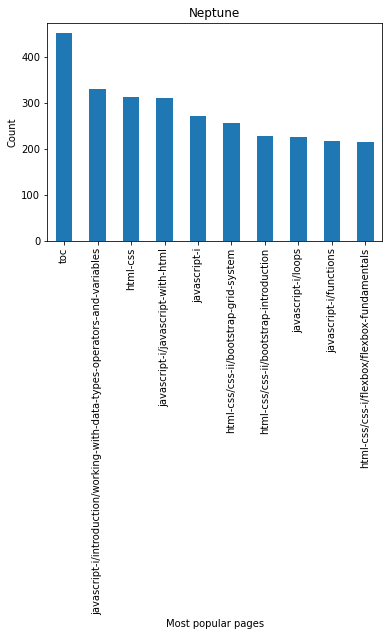

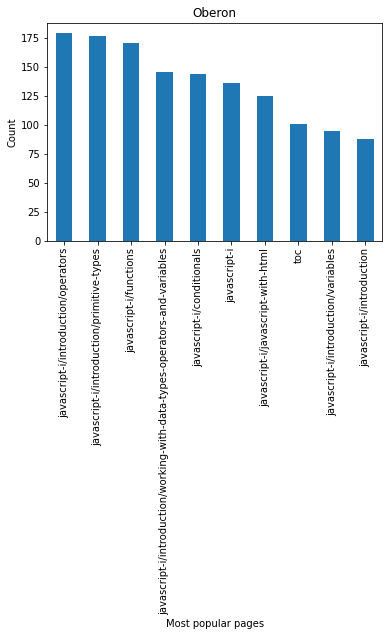

In [15]:
for program in df_dw.program_name.unique():
    plt.title(program)
    for cohort in df_dw.cohort_name.unique():
        plt.title(cohort)
        df_dw[df_dw['cohort_name'] == cohort].endpoint.value_counts().head(10).plot.bar()
        plt.xlabel('Most popular pages')
        plt.ylabel('Count')
        plt.show();


In [16]:
df_dw[df_dw['cohort_name'] == 'Teddy'].endpoint.value_counts().head(10)

spring           744
java-iii         732
mysql            638
javascript-i     615
java-i           522
jquery           512
java-ii          509
appendix         505
javascript-ii    487
mysql/tables     387
Name: endpoint, dtype: int64

In [31]:
df_dw.groupby('endpoint').cohort_name.value_counts().to_frame()

cohort_name
endpoint                         cohort_name             
%20https://github.com/RaulCPena  Curie                  1
'                                Staff                  1
,%20https://github.com/RaulCPena Curie                  1
.git                             Voyageurs              1
.gitignore                       Darden                 1
...                                                   ...
where                            Florence               1
working-with-time-series-data    Darden                14
                                 Staff                  1
wp-admin                         Teddy                  1
wp-login                         Teddy                  1

[13138 rows x 1 columns]

In [40]:
df_dw[df_dw['cohort_name'] == 'Darden'].endpoint.value_counts().head(10).to_frame().reset_index()

,index,endpoint
0,classification/overview,1109
1,sql/mysql-overview,774
2,anomaly-detection/overview,592
3,1-fundamentals/1.1-intro-to-data-science,460
4,stats/compare-means,423
5,classification/logistic-regression,423
6,classification/prep,367
7,classification/explore,352
8,classification/evaluation,336
9,fundamentals/intro-to-data-science,305


In [33]:
for index in df_dw[df_dw['cohort_name'] == 'Europa'].endpoint.value_counts().head(10).to_frame().reset_index():
    print(index)
    

index
endpoint


3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [47]:
df_dw

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,created_at,updated_at,program_id,date_time,program_name
date,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:02,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:05,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:06,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,2018-01-26 09:56:24,Java Full Stack Web Development
2018-01-26,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,2018-01-26 09:56:41,Java Full Stack Web Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,2021-04-21 16:41:51,Java Full Stack Web Development
2021-04-21,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,2021-04-21 16:42:02,Java Full Stack Web Development
2021-04-21,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,2021-04-21 16:42:09,Java Full Stack Web Development


In [58]:
 df_dw[df_dw['date'] < df_dw['end_date']].groupby('user_id').endpoint.count().sort_values(ascending = True).to_frame()

,endpoint
user_id,
832,2
278,3
679,4
539,4
956,4
...,...
555,2757
823,2807
671,2980


In [ ]:
df_dw[df_dw['date'] < df_dw['end_date']][df_dw['user_id'] == 278]

In [ ]:
[df_dw['user_id'] == 278]

4. Is there any suspicious activity, such as users/machines/etc. accessing the curriculum who shouldn't be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [45]:
df_dw.source_ip.nunique()

4947

In [48]:
 df_dw[df_dw['date'] > df_dw['end_date']]

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,created_at,updated_at,program_id,date_time,program_name
date,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:02,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:05,PHP Full Stack Web Development
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:06,PHP Full Stack Web Development
2018-01-26,2018-01-26,10:14:51,javascript-i,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 10:14:51,PHP Full Stack Web Development
2018-01-26,2018-01-26,10:15:02,javascript-i/functions,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 10:15:02,PHP Full Stack Web Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,2021-04-21 16:41:51,Java Full Stack Web Development
2021-04-21,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,2021-04-21 16:42:02,Java Full Stack Web Development
2021-04-21,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,2021-04-21 16:42:09,Java Full Stack Web Development


5. At some point in 2019, the ability for students an alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [ ]:
df_dw[df_dw['date'] > df_dw['end_date']]

7. Which lessons are leasts accessed?

8. Anything else I should be aware of?